## Install Required Libraries

In [1]:
!pip install flask-ngrok
!pip install networkx
!pip install tabula-py
!pip install texttable
!pip install pyvis
!pip install pyproj==1.9.6
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759571 sha256=6883e751eaa2cf1aa00e6fb91da75fcfe2c6ce1730122e9fa88c500d0139fc58
  Stored in directory: /tmp/pip-ephem-wheel-cache-9v7y7vua/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


# Import Libraries

In [2]:
import math
import pickle
import base64
import tabula
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import texttable as tt
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.lines as mlines
from pyvis.network import Network
from itertools import combinations
from scipy.optimize import curve_fit
from mpl_toolkits.basemap import Basemap as Basemap

## Mount Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')
!ls "/content/drive/MyDrive/NetworkScience"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Air Asia_WS2020.pdf'	    interactive-vis.html     shortestpath.html
'Air India_WS2020.pdf'	    map.html		     shortestpathresult.html
 AirportCode.xlsx	    nx.html		     SpiceJet_WS2020.pdf
 AirportLatLong.xlsx	   'Pawan Hans_WS2020.pdf'  'Star Air_WS2020.pdf'
'Alliance Air_WS2020.pdf'   schedule_dict1.pk	     static
 dashboard.html		    schedule_dict2.pk	     styles.css
 figures.html		    schedule_dict3.pk	     Trujet_WS2020.pdf
'Go Air_WS2020.pdf'	    schedule_list1.pk	     Vistara_WS2020.pdf
 India_SHP.zip		    schedule_list2.pk	     visualization.html
 Indigo_WS2020.pdf	    schedule_list3.pk	     webapp.html


# Airport Network Data Extraction from DGCA

## Fetching Airport Codes

In [4]:
"""
Function         : getAirportCodeMapping
Source of Data   : https://airportcodes.io/en/country/india/
Input Parameters : None
Purpose          : Fetches the airports and corresponding codes from the xlsx file
Returns          : A dictionary containing airport code corresponding to the airport and airport corresponding to the airport code.
"""

def getAirportCodeMapping():
    airport_code = pd.read_excel("/content/drive/MyDrive/NetworkScience/AirportCode.xlsx")    # Read the Airport Code file
    airport_code_map = {}
    reverse_airport_map = {}
    for i in range(airport_code.shape[0]):                                                    # For each row in airport code
        row = airport_code.iloc[i]
        airport_code_map[row['City']] = row['Code']
        if row['Code'] not in reverse_airport_map:
            reverse_airport_map[row['Code']] = row['City']
    return airport_code_map, reverse_airport_map                                              # Return Airport Code map and reverse airport code map

## Data Extraction from Flight Schedules of air-travel service providers

In [5]:
"""
Function         : fetchFlights
Input Parameters : 
                    file_names_list  - all files to be parsed
                    column_list_if   - columns to be set in if statement
                    column_list_else - columns to be set in case of else statement
                    drop_column_if   - drop the Unnamed column specified
                    drop_rows_list   - list of rows to be dropped from the beginning of each page
                    schedule_dict    - a dictionary containing list of dataframes corresponding to each airline
                    
Purpose          : Reads the tables given in flight schedule and returns a list of list of dataframes corresponding to each page of schedule
Returns          : Returns a list of list of dataframes corresponding to each page of schedule, and a dictionary containing the list of dataframes corresponding to each airline.
"""
def fetchFlights(file_names_list, column_list_if, column_list_else, check_column_if, drop_column_if, drop_rows_list, schedule_dict):
    schedule_list = []
    for file in file_names_list:
        table = tabula.read_pdf("/content/drive/MyDrive/NetworkScience/" + file + ".pdf",pages="all")             # Read the pdf file
        
        for i in range(len(table)):                                                                               # For each page of schedule present in each file
            if check_column_if in table[i].columns:                                                               # Check if 'Unnamed' column has crept in while reading the pdf
                table[i] = table[i].drop(drop_column_if, axis = 1)                                                # Drop the 'Unnamed' column
                table[i].columns = column_list_if                                                                 # Set the columns
            else:                                                                                                 # For all the other cases
                table[i].columns = column_list_else                                                               # Set the columns
                table[i]["Arrival from"] = table[i]['Arrival from'].str.cat(table[i]['Arrival Time'], sep =" ")   # Append Arrival Time to Arrival From
                table[i].rename(columns = {'Arrival from':'Arrival from and Time'}, inplace = True)               # Rename the column
                table[i] = table[i].drop('Arrival Time', axis = 1)                                                # Drop the unnecessary column

            table[i] = table[i].drop(drop_rows_list)                                                              # Drop the unnecessary rows
            table[i] = table[i].reset_index(drop=True)                                                            # Reset the indexes
        schedule_list.append(table)                                                                               # Append list of dataframe to schedule_list
        schedule_dict[file] = table                                                                               # Assign list of dataframe against the airline
    return schedule_list, schedule_dict                                                                           # Return list of list and dictionary

In [6]:
"""
Function         : fetchFlightSpecialCase
Input Parameters : 
                    file_names_list  - all files to be parsed
                    column_list      - columns to be set
                    drop_rows_list   - list of rows to be dropped from the beginning of each page
                    schedule_dict    - a dictionary containing list of dataframes corresponding to each airline
                    
Purpose          : Reads the tables given in flight schedule(specifically for Pawan Hans) and returns a list of list of dataframes corresponding to each page of schedule
Returns          : Returns a list of list of dataframes corresponding to each page of schedule, and a dictionary containing the list of dataframes corresponding to each airline.
"""
def fetchFlightSpecialCase(file_names_list, columns_list, drop_rows_list, schedule_dict):
    schedule_list = []
    for file in file_names_list:
        table = tabula.read_pdf("/content/drive/MyDrive/NetworkScience/" + file + ".pdf",pages="all")             # Read the pdf file

        for i in range(len(table)):                                                                               # For each page of schedule present in each file
            table[i].columns = columns_list                                                                       # Set the columns
            table[i]["Arrival from"] = table[i]['Arrival from'].str.cat(table[i]['Arrival Time'], sep =" ")       # Append Arrival Time to Arrival From
            table[i].rename(columns = {'Arrival from':'Arrival from and Time'}, inplace = True)                   # Rename the column
            table[i] = table[i].drop('Arrival Time', axis = 1)                                                    # Drop the unnecessary column

            table[i] = table[i].drop(drop_rows_list)                                                              # Drop the unnecessary rows
            table[i] = table[i].reset_index(drop=True)                                                            # Reset the indexes
        schedule_list.append(table)                                                                               # Append list of dataframe to schedule_list
        schedule_dict[file] = table                                                                               # Assign list of dataframe against the airline
    return schedule_list, schedule_dict                                                                           # Return list of list and dictionary

In [7]:
"""
Function         : makeUnweightedANI
Input Parameters : 
                    schedule_list    - list of list of dataframes retrieved from fetchFlights method
                    check_column     - columns to be checked to identify new city row
                    DG               - Directed Graph
                    
Purpose          : Reads the tables and adds the directed edges into the DiGraph
Returns          : Returns a unweighted DiGraph.
"""
def makeUnweightedANI(schedule_list, check_column, DG):
    for table in schedule_list:                                                                                         # For each airline schedule
        first_airport = ""
        second_airport = ""

        for j in range(len(table)):                                                                                     # For each page of schedule present in each file
            for i in range(table[j].shape[0]):                                                                          # For each row present in schedule
                row = table[j].iloc[i]                                                                                  # Capture the row
                if not isinstance(row[check_column], str) and math.isnan(row[check_column]):                            # If the row is a heading row
                    if row['Arrival from and Time'] in airport_code_map:                                                # If the value of Arrival From and Time column is present
                        first_airport = airport_code_map[row['Arrival from and Time']]                                  # Capture the IATA Code for the heading city present in schedule
                    else:                                                                                               # For all other cases
                        print("Airport Code not present for:", row['Arrival from and Time'])
                else:
                    if not isinstance(row['Arrival from and Time'], str) and math.isnan(row['Arrival from and Time']):  # If Arrival From and Time is not present 
                        second_airport = row['Departure to']                                                            # Get the second airport from Departure To column
                        DG.add_edge(first_airport, second_airport)                                                      # Add edge from first airport to second airport
                    else:                                                                                               # For all the other cases
                        second_airport = row['Arrival from and Time'].split()[0]                                        # Get the second Airport from Arrival From and Time column
                        DG.add_edge(second_airport, first_airport)                                                      # Add edge from second airport to first airport
    return DG                                                                                                           # Return Unweighted graph thus obtained

In [8]:
"""
Function         : makeUnweightedANISpecialCase
Input Parameters : 
                    schedule_list    - list of list of dataframes retrieved from fetchFlights method
                    DG               - Directed Graph
                    
Purpose          : Reads the tables and adds the directed edges into the DiGraph (Special case for Pawan Hans)
Returns          : Returns a unweighted DiGraph.
"""
def makeUnweightedANISpecialCase(schedule_list, DG):
    for table in schedule_list:                                                                                         # For each airline schedule
        first_airport = ""
        second_airport = ""
        for j in range(len(table)):                                                                                     # For each page of schedule present in each file
            for i in range(table[j].shape[0]):                                                                          # For each row present in schedule
                row = table[j].iloc[i]                                                                                  # Capture the row
                if i == 6:                                                                                              # Special Case of Jorhat
                    row['Frequency'] = 'Jorhat'
                elif i == 11:                                                                                           # Special Case of Tezpur
                    row['Frequency'] = 'Tezpur'
                if not isinstance(row['Sl. No.'], str) and math.isnan(row['Sl. No.']):                                  # If the row is heading row
                    if row['Frequency'] in airport_code_map:                                                            # If the value of Frequency is present(it contains City name)
                        first_airport = airport_code_map[row['Frequency']]                                              # Capture IATA code of heading city
                    else:                                                                                               # For all other cases
                        print("Airport Code not present for:", row['Frequency'])
                else:
                    if not isinstance(row['Arrival from and Time'], str) and math.isnan(row['Arrival from and Time']):  # If Arrival From and Time is not present     
                        second_airport = row['Departure to']                                                            # Get the second airport from Departure To column
                        DG.add_edge(first_airport, second_airport)                                                      # Add edge from first airport to second airport
                    else:                                                                                               # For all the other cases
                        second_airport = row['Arrival from and Time'].split()[0]                                        # Get the second Airport from Arrival From and Time column
                        DG.add_edge(second_airport, first_airport)                                                      # Add edge from second airport to first airport
    return DG                                                                                                           # Return Unweighted graph thus obtained

In [9]:
"""
Function         : makeWeightedANI
Input Parameters : 
                    schedule_list    - list of list of dataframes retrieved from fetchFlights method
                    check_column     - columns to be checked to identify new city row
                    DG               - Directed Graph
                    
Purpose          : Reads the tables and adds the directed edges into the DiGraph
Returns          : Returns a Weighted DiGraph.
"""
def makeWeightedANI(schedule_list, check_column, DG):
    for table in schedule_list:                                                                                         # For each airline schedule
        first_airport = ""
        second_airport = ""

        for j in range(len(table)):                                                                                     # For each page of schedule present in each file
            for i in range(table[j].shape[0]):                                                                          # For each row present in schedule
                row = table[j].iloc[i]                                                                                  # Capture the row
                if not isinstance(row[check_column], str) and math.isnan(row[check_column]):                            # If the row is a heading row
                    if row['Arrival from and Time'] in airport_code_map:                                                # If the value of Arrival From and Time column is present
                        first_airport = airport_code_map[row['Arrival from and Time']]                                  # Capture the IATA Code for the heading city present in schedule
                    else:                                                                                               # For all other cases
                        print("Airport Code not present for:", row['Arrival from and Time'])
                else:                                                                                                   # For all other cases
                    freq = row['Frequency']                                                                             # Capture the frequency
                    if freq == 'Daily':                                                                                 # If the frequency value is Daily
                        number_flights = 7                                                                              # number of flights to be assigned as 7
                    else:                                                                                               # Else
                        number_flights = len(str(int(str(freq).replace(".",""))))                                       # Count the length of the string
                    if not isinstance(row['Arrival from and Time'], str) and math.isnan(row['Arrival from and Time']):  # If Arrival From and Time is not present 
                        second_airport = row['Departure to']                                                            # Get the second airport from Departure To column
                        if DG.has_edge(first_airport, second_airport):                                                  # If the edge is already present in the DiGraph
                            prev_weight = DG.get_edge_data(first_airport, second_airport)                               # Fetch the previous weight of the edge
                            prev_weight = prev_weight['weight']                                                         # Fetch the previous weight of the edge
                            number_flights += prev_weight                                                               # Add the current frequency to the previous weight
                        DG.add_edge(first_airport, second_airport)                                                      # Add the edge into the DiGraph
                        DG[first_airport][second_airport]['weight'] = number_flights                                    # Assign the updated number of flights
                    else:                                                                                               # For all other cases
                        second_airport = row['Arrival from and Time'].split()[0]                                        # Get the second Airport from Arrival From and Time column  
                        if DG.has_edge(second_airport, first_airport):                                                  # If the edge is already present in the DiGraph
                            prev_weight = DG.get_edge_data(second_airport, first_airport)                               # Fetch the previous weight of the edge
                            prev_weight = prev_weight['weight']                                                         # Fetch the previous weight of the edge
                            number_flights += prev_weight                                                               # Add the current frequency to the previous weight
                        DG.add_edge(second_airport, first_airport)                                                      # Add the edge into the DiGraph
                        DG[second_airport][first_airport]['weight'] = number_flights                                    # Assign the updated number of flights
    return DG                                                                                                           # Return the Weighted graph thus obtained

In [10]:
"""
Function         : makeWeightedANISpecialCase
Input Parameters : 
                    schedule_list    - list of list of dataframes retrieved from fetchFlights method
                    DG               - Directed Graph
                    
Purpose          : Reads the tables and adds the directed edges into the DiGraph (Special case for Pawan Hans)
Returns          : Returns a Weighted DiGraph.
"""
def makeWeightedANISpecialCase(schedule_list, DG):
    for table in schedule_list:                                                                                         # For each airline schedule
        first_airport = ""
        second_airport = ""
        for j in range(len(table)):                                                                                     # For each page of schedule present in each file
            for i in range(table[j].shape[0]):                                                                          # For each row present in schedule
                row = table[j].iloc[i]                                                                                  # Capture the row
                if i == 6:                                                                                              # Special Case of Jorhat
                    row['Frequency'] = 'Jorhat'
                elif i == 11:                                                                                           # Special Case of Tezpur
                    row['Frequency'] = 'Tezpur'
                if not isinstance(row['Sl. No.'], str) and math.isnan(row['Sl. No.']):                                  # If the row is heading row
                    if row['Frequency'] in airport_code_map:                                                            # If the value of Frequency is present(it contains City name)
                        first_airport = airport_code_map[row['Frequency']]                                              # Capture IATA code of heading city
                    else:                                                                                               # For all other cases
                        print("Airport Code not present for:", row['Frequency'])
                else:                                                                                                   # For all other cases
                    freq = row['Frequency']                                                                             # Capture the frequency
                    if freq == 'Daily':                                                                                 # If the frequency value is Daily
                        number_flights = 7                                                                              # number of flights to be assigned as 7
                    else:                                                                                               # Else
                        number_flights = len(str(int(str(freq).replace(".",""))))                                       # Count the length of the string
                    if not isinstance(row['Arrival from and Time'], str) and math.isnan(row['Arrival from and Time']):  # If Arrival From and Time is not present 
                        second_airport = row['Departure to']                                                            # Get the second airport from Departure To column
                        
                        if DG.has_edge(first_airport, second_airport):                                                  # If the edge is already present in the DiGraph
                            prev_weight = DG.get_edge_data(first_airport, second_airport)                               # Fetch the previous weight of the edge
                            prev_weight = prev_weight['weight']                                                         # Fetch the previous weight of the edge
                            number_flights += prev_weight                                                               # Add the current frequency to the previous weight
                        DG.add_edge(first_airport, second_airport)                                                      # Add the edge into the DiGraph
                        DG[first_airport][second_airport]['weight'] = number_flights                                    # Assign the updated number of flights
                    else:                                                                                               # For all other cases
                        second_airport = row['Arrival from and Time'].split()[0]                                        # Get the second Airport from Arrival From and Time column  
                        if DG.has_edge(second_airport, first_airport):                                                  # If the edge is already present in the DiGraph
                            prev_weight = DG.get_edge_data(second_airport, first_airport)                               # Fetch the previous weight of the edge
                            prev_weight = prev_weight['weight']                                                         # Fetch the previous weight of the edge
                            number_flights += prev_weight                                                               # Add the current frequency to the previous weight
                        DG.add_edge(second_airport, first_airport)                                                      # Add the edge into the DiGraph
                        DG[second_airport][first_airport]['weight'] = number_flights                                    # Assign the updated number of flights
    return DG                                                                                                           # Return the Weighted graph thus obtained

In [11]:
"""
Function         : printDGStatistics
Input Parameters : 
                    DG_unweighted    - Directed Unweighted Graph
                    DG_weighted      - Directed Weighted Graph
                    
Purpose          : Prints the edges and nodes present in unweighted and weighted graphs
Returns          : Nothing.
"""

def printDGStatistics(DG_unweighted, DG_weighted):
    print("DG_unweighted.edges():", len(DG_unweighted.edges()))                 # Prints number of edges present in Unweighted DiGraph
    print("DG_unweighted.nodes():", len(DG_unweighted.nodes()))                 # Prints number of nodes present in Unweighted DiGraph

    print("DG_weighted.edges():", len(DG_weighted.edges()))                     # Prints number of edges present in Weighted DiGraph
    print("DG_weighted.nodes():", len(DG_weighted.nodes()))                     # Prints number of nodes present in Weighted DiGraph

In [12]:
DG_unweighted = nx.DiGraph()                                                    # Creates a new unweighted directed graph
DG_weighted = nx.DiGraph()                                                      # Creates a new weighted directed graph
airport_code_map, reverse_airport_map = getAirportCodeMapping()  # Gets the airport code map(City:IATA) and reverse airport map(IATA:City)

In [13]:
# Source - https://www.dgca.gov.in/digigov-portal/?page=4201/4200/servicename

file_names_list1 = ["Air Asia_WS2020", "Go Air_WS2020", "Indigo_WS2020", "Star Air_WS2020", "Vistara_WS2020"]                  # Set the file names to parse

column_list_if = ["Sl. No.", "Flight No.", "Operator Code", "Aircraft Type", "Frequency", "Arrival from and Time",  
                    "Departure to", "Departure Time", "Effective from", "Effective to"]                                        # Set the columns names to assign in if statement

column_list_else = ["Sl. No.", "Flight No.", "Operator Code", "Aircraft Type", "Frequency", "Arrival from", "Arrival Time",  
                      "Departure to", "Departure Time", "Effective from", "Effective to"]                                      # Set the columns names to assign in else statement

check_column_if = 'Unnamed: 2'                                                                                                 # Column to check in if statement
drop_column_if = 'Unnamed: 2'                                                                                                  # Column to drop in if statement
drop_rows_list = [0, 1]                                                                                                        # Rows to drop 

pickle_schedule_list1 = open ("/content/drive/MyDrive/NetworkScience/schedule_list1.pk", "rb")                                 # Fetch the schedule_list1 pickle from the drive
schedule_list = pickle.load(pickle_schedule_list1)                                                                             # Load the pickle
pickle_schedule_dict1 = open ("/content/drive/MyDrive/NetworkScience/schedule_dict1.pk", "rb")                                 # Fetch the schedule_dict1 pickle from the drive
schedule_dict = pickle.load(pickle_schedule_dict1)                                                                             # Load the pickle
# schedule_dict = {}                                                                                                           # Make new empty dictionary
# schedule_list, schedule_dict = fetchFlights(file_names_list1, column_list_if, column_list_else, check_column_if, drop_column_if, drop_rows_list, schedule_dict) # Fetch the schedule from the airline schedule present as pdf
# with open('/content/drive/MyDrive/NetworkScience/schedule_list1.pk', 'wb') as fh:                                            # Dump the schedule_list1 as a pickle on drive
#    pickle.dump(schedule_list, fh)
# with open('/content/drive/MyDrive/NetworkScience/schedule_dict1.pk', 'wb') as fh:                                            # Dump the schedule_dict1 as a pickle on drive
#    pickle.dump(schedule_dict, fh)

check_column = 'Sl. No.'                                                                                                       # Column to be checked while making DiGraph
DG_unweighted = makeUnweightedANI(schedule_list, check_column, DG_unweighted)                                                  # Gets the unweighted Digraph pf ANI
DG_weighted = makeWeightedANI(schedule_list, check_column, DG_weighted)                                                        # Gets the weighted DiGraph of ANI

In [14]:
printDGStatistics(DG_unweighted, DG_weighted)

DG_unweighted.edges(): 539
DG_unweighted.nodes(): 65
DG_weighted.edges(): 539
DG_weighted.nodes(): 65


In [15]:
file_names_list = ["Air India_WS2020", "Alliance Air_WS2020", "SpiceJet_WS2020", "Trujet_WS2020"]                              # Set the file names to parse

column_list_if = ["Sl. No. and Flight No.", "Operator Code", "Aircraft Type", "Frequency", "Arrival from and Time",  
                            "Departure to", "Departure Time", "Effective from", "Effective to"]                                # Set the columns names to assign in if statement

column_list_else = ["Sl. No. and Flight No.", "Operator Code", "Aircraft Type", "Frequency", "Arrival from", "Arrival Time",  
                            "Departure to", "Departure Time", "Effective from", "Effective to"]                                # Set the columns names to assign in else statement

check_column_if = 'Unnamed: 1'                                                                                                 # Column to check in if statement
drop_column_if = 'Unnamed: 0'                                                                                                  # Column to drop in if statement
drop_rows_list = [0]                                                                                                           # Rows to drop 

pickle_schedule_list2 = open ("/content/drive/MyDrive/NetworkScience/schedule_list2.pk", "rb")                                 # Fetch the schedule_list2 pickle from the drive
schedule_list = pickle.load(pickle_schedule_list2)                                                                             # Load the pickle
pickle_schedule_dict2 = open ("/content/drive/MyDrive/NetworkScience/schedule_dict2.pk", "rb")                                 # Fetch the schedule_dict2 pickle from the drive
schedule_dict = pickle.load(pickle_schedule_dict2)                                                                             # Load the pickle
# schedule_list, schedule_dict = fetchFlights(file_names_list, column_list_if, column_list_else, check_column_if, drop_column_if, drop_rows_list, schedule_dict) # Fetch the schedule from the airline schedule present as pdf
# with open('/content/drive/MyDrive/NetworkScience/schedule_list2.pk', 'wb') as fh:                                            # Dump the schedule_list2 as a pickle on drive
#    pickle.dump(schedule_list, fh)
# with open('/content/drive/MyDrive/NetworkScience/schedule_dict2.pk', 'wb') as fh:                                            # Dump the schedule_dict2 as a pickle on drive
#    pickle.dump(schedule_dict, fh)

check_column = 'Sl. No. and Flight No.'                                                                                        # Column to be checked while making DiGraph
DG_unweighted = makeUnweightedANI(schedule_list, check_column, DG_unweighted)                                                  # Gets the unweighted Digraph pf ANI
DG_weighted = makeWeightedANI(schedule_list, check_column, DG_weighted)                                                        # Gets the weighted DiGraph of ANI

In [16]:
printDGStatistics(DG_unweighted, DG_weighted)

DG_unweighted.edges(): 740
DG_unweighted.nodes(): 99
DG_weighted.edges(): 740
DG_weighted.nodes(): 99


In [17]:
file_names_list = ["Pawan Hans_WS2020"]                                                                                # Set the file names to parse

column_list = ["Sl. No.", "Flight No.", "Operator Code", "Aircraft Type", "Frequency", "Arrival from", "Arrival Time",  
                        "Departure to", "Departure Time", "Effective from", "Effective to"]                            # Set the columns names to assign

drop_rows_list = [0, 1]                                                                                                # Rows to drop 

pickle_schedule_list3 = open ("/content/drive/MyDrive/NetworkScience/schedule_list3.pk", "rb")                         # Fetch the schedule_list3 pickle from the drive
schedule_list = pickle.load(pickle_schedule_list3)                                                                     # Load the pickle
pickle_schedule_dict3 = open ("/content/drive/MyDrive/NetworkScience/schedule_dict3.pk", "rb")                         # Fetch the schedule_dict3 pickle from the drive
schedule_dict = pickle.load(pickle_schedule_dict3)                                                                     # Load the pickle
# schedule_list, schedule_dict = fetchFlightSpecialCase(file_names_list, column_list, drop_rows_list, schedule_dict)   # Fetch the schedule from the airline schedule present as pdf
# with open('/content/drive/MyDrive/NetworkScience/schedule_list3.pk', 'wb') as fh:                                    # Dump the schedule_list3 as a pickle on drive
#    pickle.dump(schedule_list, fh)
# with open('/content/drive/MyDrive/NetworkScience/schedule_dict3.pk', 'wb') as fh:                                    # Dump the schedule_dict3 as a pickle on drive
#    pickle.dump(schedule_dict, fh)

DG_unweighted = makeUnweightedANISpecialCase(schedule_list, DG_unweighted)                                             # Gets the unweighted Digraph pf ANI
DG_weighted = makeWeightedANISpecialCase(schedule_list, DG_weighted)                                                   # Gets the weighted DiGraph of ANI

In [18]:
printDGStatistics(DG_unweighted, DG_weighted)

DG_unweighted.edges(): 745
DG_unweighted.nodes(): 99
DG_weighted.edges(): 745
DG_weighted.nodes(): 99


In [19]:
# Checking Symmetricity of the Airport Network
edge_list = DG_unweighted.edges()                                               # Get the edges present in the unweighted DiGraph
bidirectional_edge_list = []
unidirectional_edge_list = []
for edge in DG_unweighted.edges():                                              # For each of the edge present in the edge_list
    (u, v) = edge                                                               # Capture the tuple in the form of u and v
    if (v, u) in edge_list:                                                     # If reverse edge is present in the edge_list
        bidirectional_edge_list.append((u, v))                                  # Add current edge to the bidirectional edge list
    else:                                                                       # Otherwise
        unidirectional_edge_list.append((u, v))                                 # Add the edge in unidirectional edge list

# print('bidirectional_edge_list:', bidirectional_edge_list)
# print('\nLength of bidirectional_edge_list:', len(bidirectional_edge_list))
# print('\nunidirectional_edge_list:', unidirectional_edge_list)
# print('\nunidirectional_edge_list:', len(unidirectional_edge_list))

DG_unweighted_symm = DG_unweighted.copy()                                       # Symmetrize the unweighted graph
for edge in unidirectional_edge_list:                                           # For each edge present in the unidirectional edge list
    u, v = edge                                                                 # Capture the edge
    DG_unweighted_symm.add_edge(v, u)                                           # Add the edge to the symmetrized unweighted DiGraph

# print(len(DG_unweighted_symm.edges()))                                          # Print number of edges in symmetrized DiGraph

In [20]:
# Airport Wise Degree Analysis

node_list = list(DG_unweighted.nodes())                                         # Get the nodes present in the unweighted DiGraph
in_degree_list = []
out_degree_list = []
total_degree = 0
for node in node_list:                                                          # For each node present in the node list
    in_degree = DG_unweighted.in_degree(node)                                   # Find the in degree of the node
    out_degree = DG_unweighted.out_degree(node)                                 # Find the out degree of the node
    in_degree_list.append(in_degree)                                            # Append the in degree value to the in degree list
    out_degree_list.append(out_degree)                                          # Append the out degree value to the out degree list
    total_degree += in_degree                                                   # Add in degree value to total degree
    total_degree += out_degree                                                  # Add out degree value to total degree

print('Sum of all In-degree:', np.sum(in_degree_list))
print('Sum of all Out-degree:', np.sum(out_degree_list))
print('total_degree:', total_degree)
    
tab = tt.Texttable()                                                            # Creates a table view and prints the information
row = [[]]
for i in range(len(node_list)):
    row.append([i+1, node_list[i], in_degree_list[i], out_degree_list[i]])
tab.add_rows(row)
tab.set_cols_align(['r','r','r', 'r'])
tab.header(['S.No.', 'Airport Code', 'In Degree', 'Out Degree'])
print(tab.draw())

Sum of all In-degree: 745
Sum of all Out-degree: 745
total_degree: 1490
+-------+--------------+-----------+------------+
| S.No. | Airport Code | In Degree | Out Degree |
+=======+==============+===========+============+
|     1 |          BLR |        50 |         50 |
+-------+--------------+-----------+------------+
|     2 |          AMD |        28 |         30 |
+-------+--------------+-----------+------------+
|     3 |          MAA |        35 |         35 |
+-------+--------------+-----------+------------+
|     4 |          DEL |        63 |         62 |
+-------+--------------+-----------+------------+
|     5 |          IXB |         9 |          9 |
+-------+--------------+-----------+------------+
|     6 |          CCU |        38 |         38 |
+-------+--------------+-----------+------------+
|     7 |          GOI |        13 |         13 |
+-------+--------------+-----------+------------+
|     8 |          PNQ |        14 |         14 |
+-------+--------------+----

In [21]:
# # Airport Wise Weight Analysis

# node_list = list(DG_weighted_symm.nodes())
# outer_edge_list = []
# in_weight_list = []
# out_weight_list = []
# total_weight = 0
# for node in node_list:
#     edge_list = DG_weighted.edges(node)
#     for edge in edge_list:
#       u, v = edge
#       if (u, v) not in outer_edge_list or (v, u) not in outer_edge_list:
#         outer_edge_list.append(edge)
#         out_weight = DG_weighted.get_edge_data(u, v)['weight']
#         out_weight_list.append(out_weight)
#         if (v, u) in DG_weighted.edges():
#           in_weight = DG_weighted.get_edge_data(v, u)['weight']
#           if in_weight != out_weight:
#             in_weight_list.append(in_weight)
#           else:
#             outer_edge_list.pop()
#             out_weight_list.pop()
#         else:
#           in_weight_list.append(0)

# print(len(outer_edge_list))

# tab = tt.Texttable()
# row = [[]]
# for i in range(len(outer_edge_list)):
#     row.append([i+1, outer_edge_list[i], out_weight_list[i], in_weight_list[i]])
# tab.add_rows(row)
# tab.set_cols_align(['r','r','r', 'r'])
# tab.header(['S.No.', 'Edge', 'Out Weight', 'In Weight'])
# print(tab.draw())

In [22]:
# Airport Wise Weight Analysis
DG_weighted_symm = DG_weighted.copy()

node_list = list(DG_weighted.nodes())
outer_edge_list = []
in_weight_list = []
out_weight_list = []
total_weight = 0
for node in node_list:
    edge_list = DG_weighted.edges(node)
    for edge in edge_list:
        u, v = edge
        if (u, v) not in outer_edge_list or (v, u) not in outer_edge_list:
            outer_edge_list.append(edge)
            out_weight = DG_weighted.get_edge_data(u, v)['weight']
            out_weight_list.append(out_weight)
            if (v, u) in DG_weighted.edges():
                in_weight = DG_weighted.get_edge_data(v, u)['weight']
                if in_weight > out_weight:
                    DG_weighted_symm.get_edge_data(u, v)['weight'] = in_weight
                else:
                    DG_weighted_symm.get_edge_data(v, u)['weight'] = out_weight
            else:
                DG_weighted_symm.add_edge(v, u)
                DG_weighted_symm.get_edge_data(v, u)['weight'] = out_weight

In [23]:
"""
Function         : findStrength
Input Parameters : 
                    DG_weighted  - weighted DiGraph
                    
Purpose          : Calculates the strength of each node, converts it to dictionary and returns it
Returns          : Returns a dictionary of strength of each node
"""

def findStrength(DG_weighted):
    strength = DG_weighted.degree(weight='weight')                                    # Finds the strength of the weighted DiGraph
    # print('strength:', strength)  
    strength_dict = dict(strength)                                                    # Converts the strength obtained into a dictionary
    # print('strength_dict:', strength_dict)
    return strength_dict                                                              # Returns strength dictionary

## Fetching the Latitude and Longitude related information of Airports

In [24]:
"""
Function         : fetchLatitudeLongitude
Input Parameters : 
                    strength_dict  - strength dictionary obtained from the findStrength method
                    
Purpose          : Reads the file containing latitudes and longitudes, capture the latitude and longitude corresponding to each airport along with the strength
Returns          : Returns a dataframe containing IATA Code, Longitude, Latitude and Strength
"""

def fetchLatitudeLongitude(strength_dict):
    airport_latlong = pd.read_excel("/content/drive/MyDrive/NetworkScience/AirportLatLong.xlsx")  # Reads the file containing latitude and longitude
    airport_latlong_map = {}
    for i in range(airport_latlong.shape[0]):                                   # For all the rows present in the file
        row = airport_latlong.iloc[i]                                           # Capture each row
        if isinstance(row['iata_code'], str):                                   # If there is any value present in the IATA Code column
            airport_latlong_map[row['iata_code']] = row['coordinates']          # Capture the Coordinates

# Capturing some coordinates not present in the file
    airport_latlong_map['GBI'] = '17.3108, 76.9508'
    airport_latlong_map['JLG'] = '20.9614, 75.6192'
    airport_latlong_map['DBR'] = '26.1977, 85.9115'
    airport_latlong_map['VDX'] = '28.7116, 77.3612'
    airport_latlong_map['HXB'] = '15.3572, 75.0849'

    airport_code_list = []
    latitude_list = []
    longitude_list = []
    strength_list = []
    for key, value in airport_code_map.items():                                 # For all the airports present in airport code map
        if value in airport_latlong_map:                                        # if the IATA Code is present in the airport_latlong_map
            airport_code_list.append(value)                                     # Append the IATA Code to the airport code list
            longitude_list.append(airport_latlong_map[value].split(',')[0])     # Split the value of latitude and longitude and append to longitude list
            latitude_list.append(airport_latlong_map[value].split(',')[1])      # and latiitude list
            if value in strength_dict:                                          # If the IATA Code is present in the strength dictionary
                strength_list.append(strength_dict[value])                      # Append the strength to strength list
            else:                                                               # Otherwise
                strength_list.append(0)                                         # Append 0 as the strength value 

    final_latlong_map = {                                                       # Make final map of latitude and longitude
        'IATA_Code' : airport_code_list,
        'Longitude' : longitude_list,
        'Latitude'  : latitude_list,
        'Strength'  : strength_list
    }

    latlong_df = pd.DataFrame(final_latlong_map)                                # Convert the map to a dataframe
    # print('latlong_df:', latlong_df)
    return latlong_df                                                           # Return the dataframe obtained

In [25]:
strength_dict = findStrength(DG_weighted)                                                    # Calls findStrength method and fetches strength dictionary
strength_dict_symm = findStrength(DG_weighted_symm)
strength_dict_symm = {k: int(v / 2) for k, v in strength_dict_symm.items()}
latlong_df = fetchLatitudeLongitude(strength_dict_symm)                                      # Calls fetchLatitudeLongitude method and fetches dataframe containing lat. long.

# Visualization

## Circular Layout Visualization

In [26]:
"""
Function         : circular_visualization
Input Parameters : 
                    DG_weighted   - weighted DiGraph
                    strength_dict - strength dictionary obtained from the findStrength method
                    
Purpose          : Displays the weighted digraph in circular layout and color the nodes on the basis of the strength of the node indicating hubs
Returns          : Nothing. Only shows the plot and saves it to the drive.
"""

def circular_visualization(DG_weighted, strength_dict):
    pos = nx.circular_layout(DG_weighted)                                                   # Capture the position from the circular layout of the Weighted DiGraph
    plt.figure(3,figsize=(20,20))                                                           # Design a figure
    nx.draw(DG_weighted,pos, with_labels=True, node_color=[v for v in strength_dict.values()], nodelist=list(strength_dict.keys()), node_size=[v for v in strength_dict.values()], font_size=13.5)
                                                                                          # Draw the network with IATA Code as labels, 
                                                                                          # defining node color and node size on the basis of strength
    plt.savefig('/content/drive/MyDrive/NetworkScience/static/images/visualization.png')    # Save the figure on the drive
    plt.show()                                                                              # Show the plot

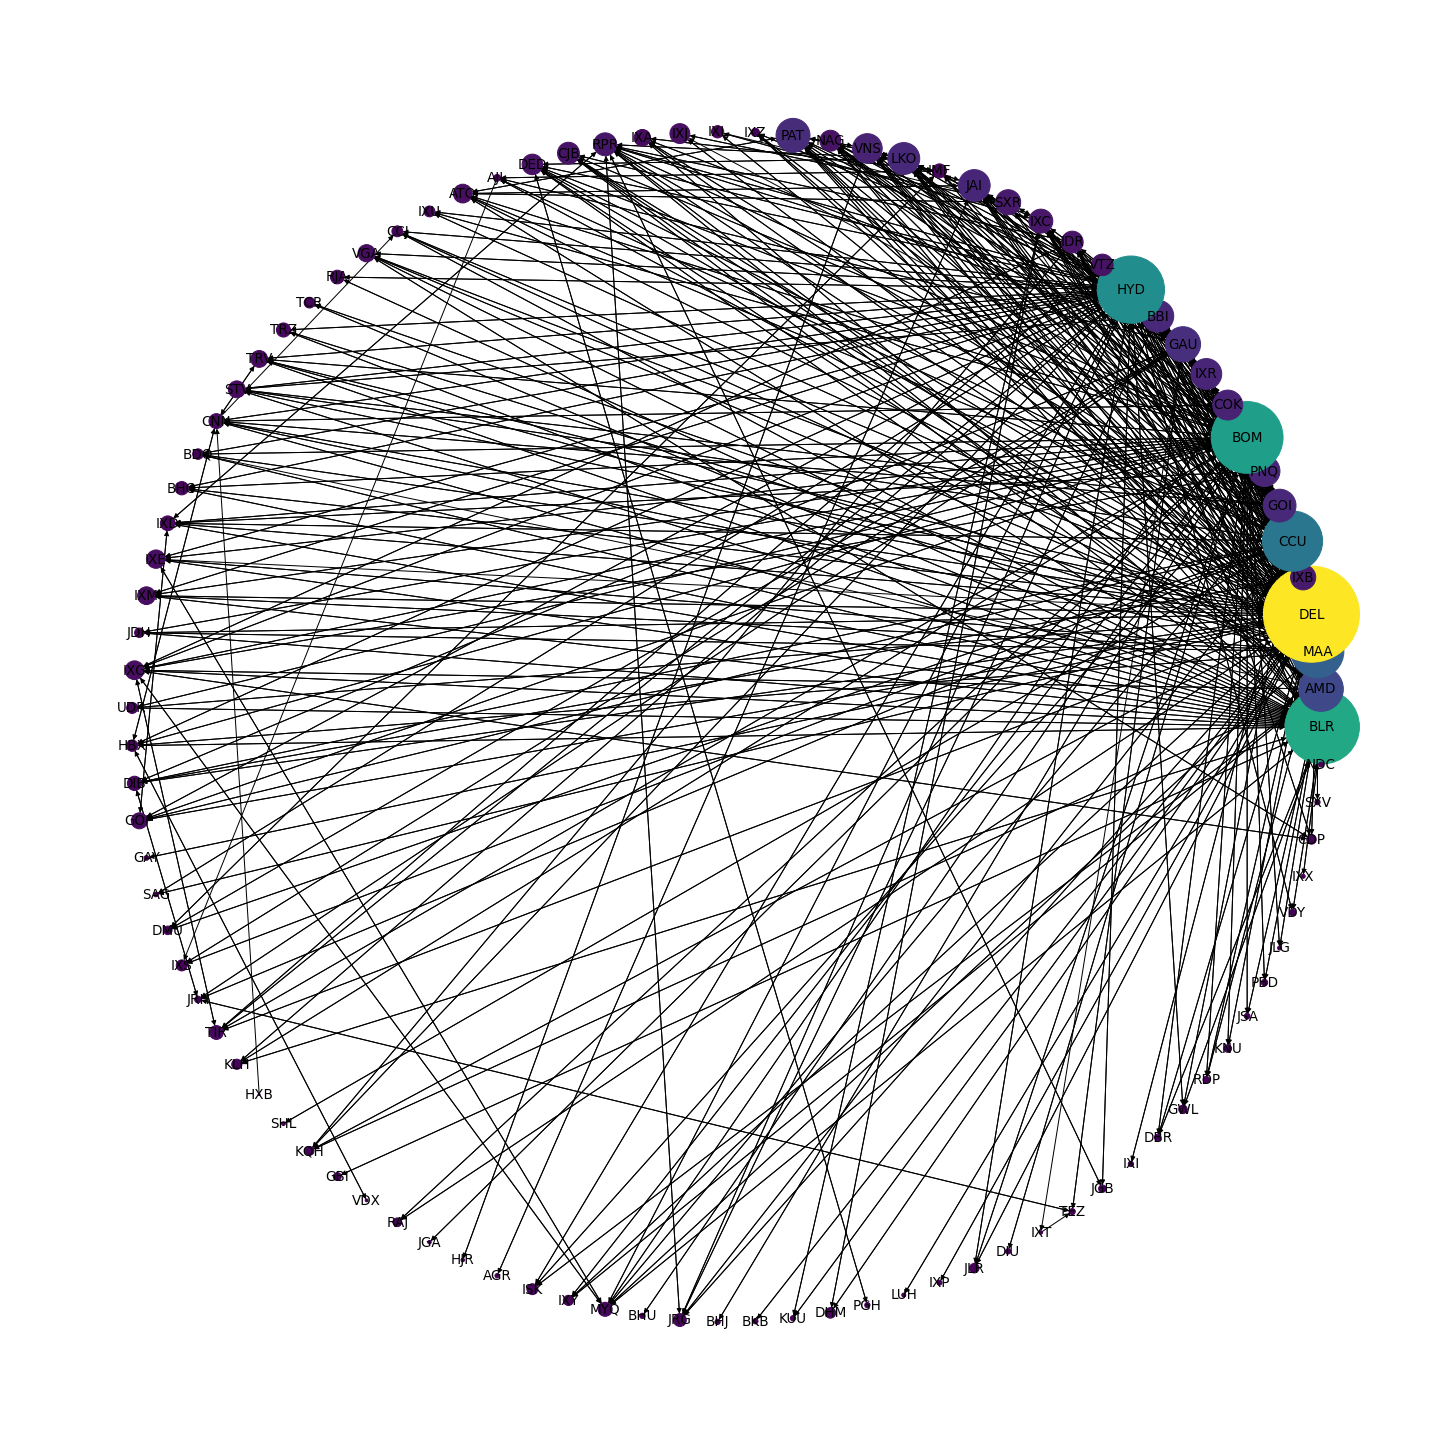

In [27]:
circular_visualization(DG_weighted, strength_dict)                                        # Calls circular_visualization

## Interactive Visualization

In [28]:
"""
Function         : interactive_visualization
Input Parameters : 
                    DG_unweighted - Unweighted DiGraph
                    
Purpose          : Displays the Unweighted DiGraph with interactive visualization
Returns          : Nothing. Only shows the plot and saves it to the drive.
"""

def interactive_visualization(DG_unweighted):
    nt = Network('1500px', '1000px')                                                      # Creates a panel to display a network
    nt.from_nx(DG_unweighted)                                                             # Draws a network from the unweighted network
    nt.show('/content/drive/MyDrive/NetworkScience/nx.html')                              # Saves the html image into the drive

In [29]:
interactive_visualization(DG_unweighted)                                                # Calls interactive_visualization

## Map Visualization

In [30]:
"""
Function         : map_visualization
Input Parameters : 
                    latlong_df - dataframe returned from fetchLatitudeLongitude 
                    
Purpose          : Displays the Weighted DiGraph on India's map
Returns          : Nothing. Only shows the plot and saves it to the drive.
"""

def map_visualization(latlong_df):
    plt.figure(figsize = (20,20))                                               # Design a figure
    m = Basemap(
          projection='merc', 
          llcrnrlon=68., llcrnrlat=6.,
          urcrnrlon=97., urcrnrlat=37., 
          resolution='l', suppress_ticks=True)                                  # Draw a basemap with bottom left and upper right lat. long.
    mx, my = m((latlong_df['Longitude'].values).astype(float), (latlong_df['Latitude'].values).astype(float))   # Assign values of latitude and longitude
    pos = {}
    for count, elem in enumerate (latlong_df['IATA_Code']):                     # Iterate over each IATA Code
        pos[elem] = (mx[count], my[count])                                      # Set the latitude and longitude value corresponding to each Airport code

    nodelist_greater = []
    strength_greater = []
    nodelist_smaller = []
    strength_smaller = []
    label_smaller_dict = {}
    label_greater_dict = {}
    for i in range(latlong_df.shape[0]):                                        # For each row present in latlong_df
        row = latlong_df.iloc[i]                                                # Capture each row
        if row['Strength'] >= 1300:                                             # For the airports with strength greater than 1300
            nodelist_greater.append(row['IATA_Code'])                           # Append the IATA to nodelist containing nodes with strength > 1300
            strength_greater.append(row['Strength']*6)                          # Append the strength to strength list
            label_greater_dict[row['IATA_Code']] = row['Strength']              # Append the labels 
        else:                                                                   # Otherwise
            nodelist_smaller.append(row['IATA_Code'])                           # Append to the nodelist containing strength less than 2500
            strength_smaller.append(row['Strength']*6)                          # Append the strength to smaller strength list
            label_smaller_dict[row['IATA_Code']] = row['Strength']              # Append the labels

    nx.draw_networkx_nodes(G = DG_weighted, pos = pos, nodelist = nodelist_greater,
                          node_color = 'r', alpha = 0.8,
                          node_size = strength_greater)                         # Draw the greater nodes

    nx.draw_networkx_labels(G = DG_weighted, pos = pos, font_size=10, labels = label_greater_dict)              # Draw the greater labels

    nx.draw_networkx_nodes(G = DG_weighted, pos = pos, nodelist = nodelist_smaller,
                          node_color = 'b', alpha = 0.6,
                          node_size = strength_smaller)                         # Draw the smaller nodes

    nx.draw_networkx_labels(G = DG_weighted, pos = pos, font_size=10,
                          labels = label_smaller_dict)                          # Draw the smaller labels

    m.drawmapboundary(fill_color='aqua')                                        # Draw the map boundary

    m.bluemarble()
    m.drawcoastlines(linewidth=1)                                               # Draw the coastal lines
    m.fillcontinents(alpha=0.7, lake_color='aqua')                              # Fill the lakes in continents with aqua color
    m.drawcountries(linewidth = 3)                                              # Draw the country boundaries
    m.drawstates(linewidth = 0.2)                                               # Draw the states

    line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")                 # Draw the legend for airports with strength greater than 2500 
    line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")                 # Draw the legend for other airports
    plt.legend((line1, line2), ('Airport with more than 1300 routes', 'Small airports'), loc=4, fontsize = 'xx-large') # Draw the legend
    plt.title("Flight Count in Airport Network of India", fontsize = 20)        # Set the title
    plt.tight_layout()                                                                                          
    plt.savefig('/content/drive/MyDrive/NetworkScience/static/images/map.png')  # Saves the figure to drive
    plt.show()                                                                  # Shows the plot.

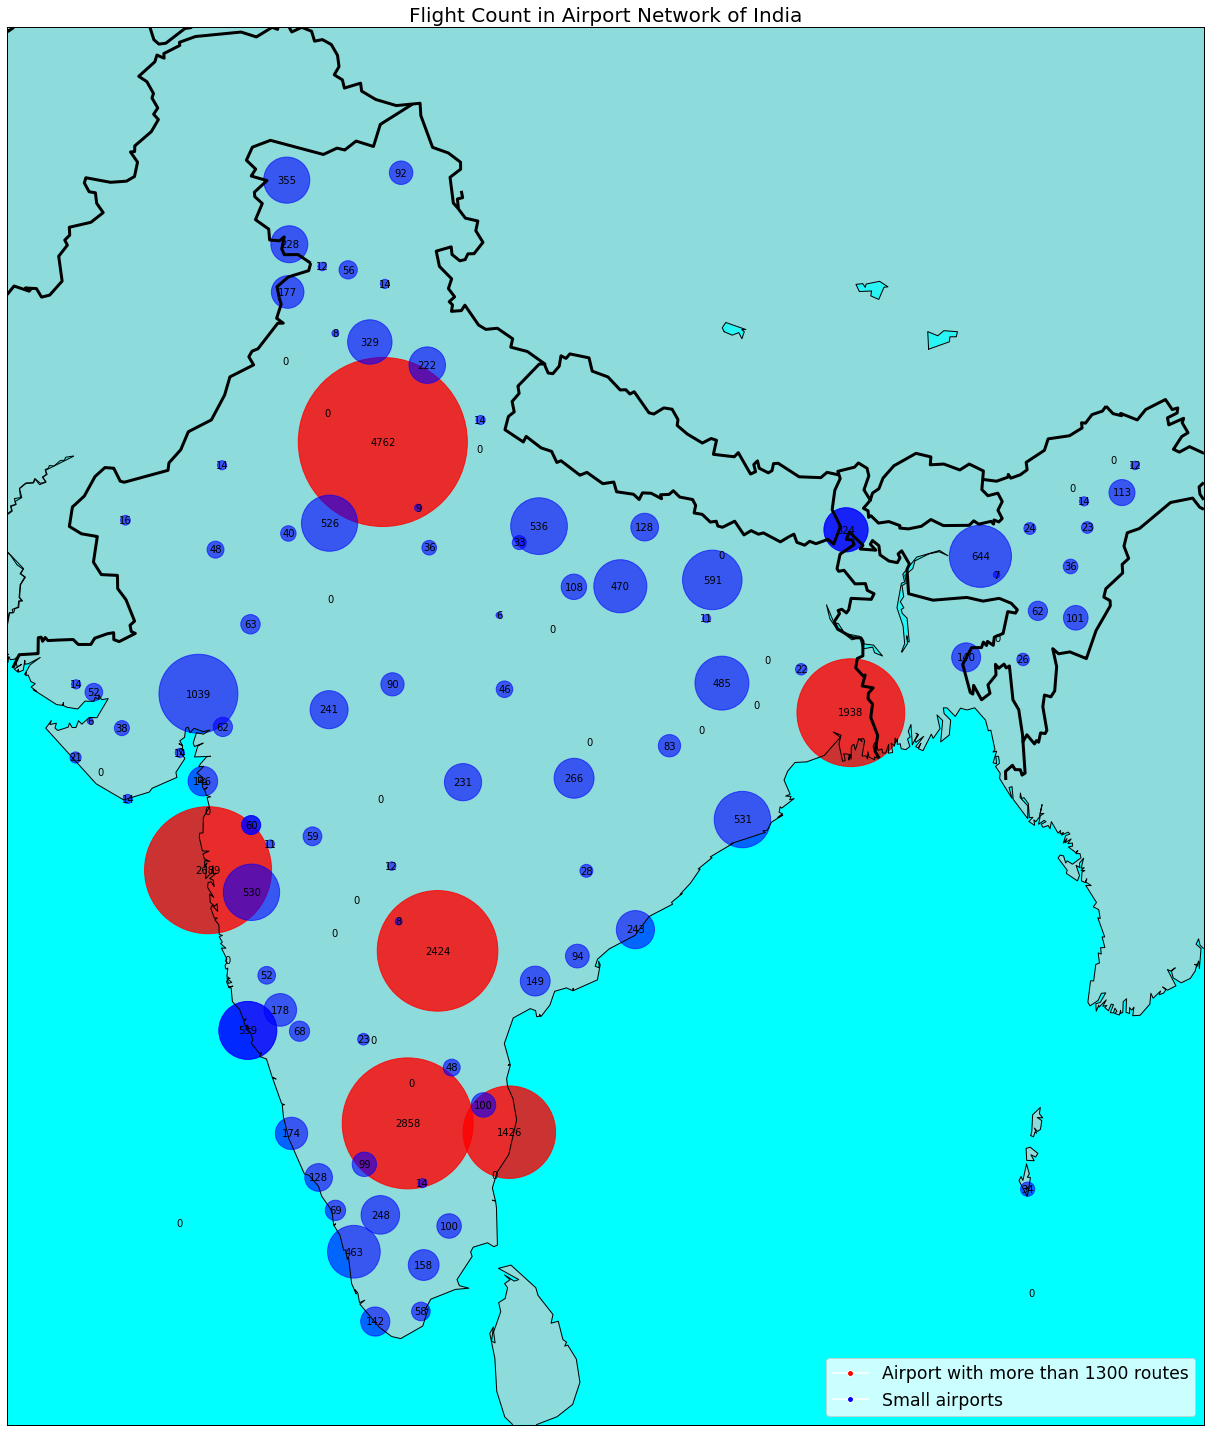

In [31]:
map_visualization(latlong_df)                                                                                 # Calls the map_visualization

# Airport Network Analysis

## Finding the Statistics

1.   Average Degree
2.   Average Shortest Path Length
3.   Average Clustering Coefficient
4.   Average Shortest Path Length of Random Network
5.   Average Clustering Coefficient of Random Network




In [32]:
"""
Function         : findUnweightedNwStats
Input Parameters : 
                    DG - Unweighted DiGraph
                    
Purpose          : Finds the statistics of unweighted DiGraph like average degree, average shortest path length, average clustering coefficient. 
                   Also it finds the average shortest path length of Random Network of comparable size, average clustering coefficient of Random Netowrk of comparable size.
Returns          : 1.   Average Degree
                   2.   Average Shortest Path Length
                   3.   Average Clustering Coefficient
                   4.   Average Shortest Path Length of Random Network
                   5.   Average Clustering Coefficient of Random Network
"""

def findUnweightedNwStats(DG):
    node_count = len(DG.nodes())                                                                # Calculates Node count
    edge_count = len(DG.edges())                                                                # Calculates Edge count
    average_degree = edge_count/node_count                                                      # Finds the average degree

    avg_shortest_path_length_ani = nx.average_shortest_path_length(DG)                          # Finds the average shortest path length of ANI
    avg_clustering_coef_ani = nx.average_clustering(DG)                                         # Finds the average clustering coefficent of ANI
    avg_shortest_path_length_rn = math.log(node_count)/math.log(average_degree)                 # Finds the average shortest path length of Random Network
    avg_clustering_coef_rn = average_degree/node_count                                          # Finds the average clustering coefficient of Random Network

    return average_degree, avg_shortest_path_length_ani, avg_clustering_coef_ani, avg_shortest_path_length_rn, avg_clustering_coef_rn # Returns the statistics calculated above

In [33]:
average_degree, avg_shortest_path_length_ani, avg_clustering_coef_ani, avg_shortest_path_length_rn, avg_clustering_coef_rn = findUnweightedNwStats(DG_unweighted)
print('Average_degree:', average_degree)
print("Average Shortest Path Length of ANI:", avg_shortest_path_length_ani)
print("Average Clustering Coefficient of ANI:", avg_clustering_coef_ani)
print("Average Shortest Path Length of Random Network:", avg_shortest_path_length_rn)
print("Average Clustering Coefficient of Random Network:", avg_clustering_coef_rn)

Average_degree: 7.525252525252525
Average Shortest Path Length of ANI: 2.1956297670583385
Average Clustering Coefficient of ANI: 0.6629876763628574
Average Shortest Path Length of Random Network: 2.276768059939733
Average Clustering Coefficient of Random Network: 0.07601265177022752


In [34]:
"""
Function         : encodeString
Input Parameters : 
                    file_name - File name of the image to be encoded
                    
Purpose          : Finds the base 64 encoding of the image file and returns the string encoded
Returns          : Encoded String
"""
def encodeString(file_name):
    encoded_string = ""
    with open("/content/drive/MyDrive/NetworkScience/static/images/"+file_name, "rb") as image_file:      # Open the image file
        encoded_string = base64.b64encode(image_file.read())                                              # Encode the string into base 64
    return encoded_string                                                                                 # Return the encoded string

## Fig 1: Plot of Shortest path distribution in ANI

In [35]:
"""
Function         : fig1
Input Parameters : 
                    DG_unweighted - Unweighted DiGraph
                    
Purpose          : Finds the path lengths and their counts
Returns          : Dictionary containing the shortest path lengths and their count
"""
def fig1(DG_unweighted):
    shortest_paths_dict = {}
    for node in DG_unweighted.nodes():                                                            # For each node present in the unweighted DiGraph
        path_length = Counter(nx.shortest_path_length(DG_unweighted,source=node).values())        # Find the shortest path length from each node and keep the count of each length
        for key,val in path_length.items():                                                       # Iterate over the dictionary of paths and their count
            if key in shortest_paths_dict:                                                        # If the path length already present in the dictionary
                shortest_paths_dict[key] = shortest_paths_dict[key] + val                         # Increment the value with the current count
            else:                                                                                 # Otherwise
                shortest_paths_dict[key] = val                                                    # Create a new key, value pair
    del shortest_paths_dict[0]                                                                    # Delete the entry with 0 path length
    print(shortest_paths_dict)
    print(shortest_paths_dict.keys())
    return shortest_paths_dict                                                                    # Return the (path, count) dictionary obtained

In [36]:
"""
Function         : plotGraph
Input Parameters : 
                    keys - Values of the X-Axis
                    values - Values of the Y-Axis
                    title  - Sets the title of the graph
                    xlabel - Sets the x-axis value
                    ylabel - Sets the y-axis value
                    fig_name - The figure name with which the figure will be saved on Google Drive
                    scatter_label - The legend label string value
                    scale - Scale value, by default = normal, if set to log, then it sets the scale of the graph to log scale on both axis 
                    set_ylim - To set the ylimit of the plot

Purpose          : Plots the graph with the requisite parameters
Returns          : Nothing. Only plots the graph and saves it to drive
"""
def plotGraph(keys, values, title, xlabel, ylabel, fig_name, scatter_label, scale='normal', set_ylim = False):
    fig = plt.figure(figsize = (10,10))                                                           # Design a figure
    if fig_name == 'fig1':                                                                        # For fig1 only
        plt.plot(keys, values)                                                                    # Plot the line between the points
    plt.scatter(keys, values, label=scatter_label)                                                # Plot the points
    if scale == 'log':                                                                            # Checks the scale
        ax=plt.gca()                                                                              # Sets the scale of both axis to the log-log scale
        ax.set_xscale('log')
        ax.set_yscale('log')
    if set_ylim:                                                                                  # Checks if there is need to set the y limit
        ax.set_ylim(ymin=1)                                                                       # Sets the ylimit ymin value
    plt.title(title)                                                                              # Set the title
    plt.xlabel(xlabel)                                                                            # Set the X-Axis label
    plt.ylabel(ylabel)                                                                            # Set the Y-Axis label
    plt.legend()                                                                                  # Show the legend
    plt.savefig('/content/drive/MyDrive/NetworkScience/static/images/'+fig_name+'.png')           # Save the figure to drive
    plt.show()                                                                                    # Show the Plot

{1: 745, 2: 6172, 3: 2538, 4: 146, 5: 3}
dict_keys([1, 2, 3, 4, 5])


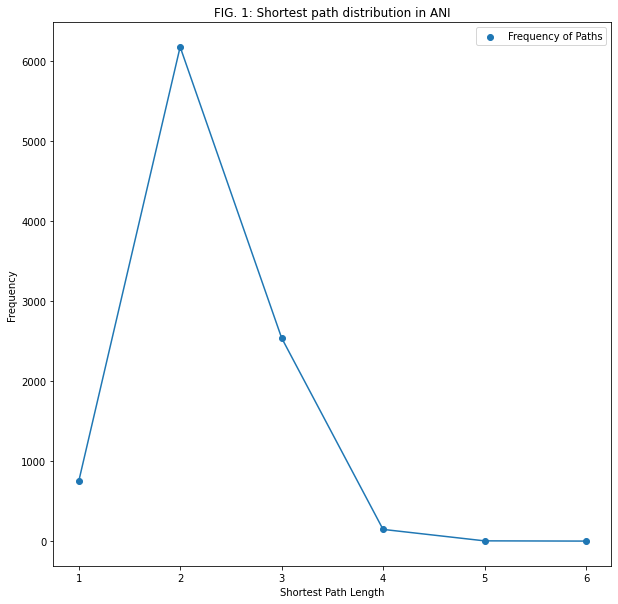

In [37]:
shortest_paths_dict = fig1(DG_unweighted)                                                     # Calls the fig1 method
keys = []
values = []
for key, value in shortest_paths_dict.items():                                                # For the path length and the frequency present in the dictionary
    keys.append(key)                                                                          # Append to the Path length list
    values.append(value)                                                                      # Append to the frequency list
keys.append(6)                                                                                # Append another path length of 6
values.append(0)                                                                              # Append the frequency as 0

scatter_label = "Frequency of Paths"                                                          # Sets the value of the legend label
title = "FIG. 1: Shortest path distribution in ANI"                                           # Sets the title of the plot
xlabel = "Shortest Path Length"                                                               # Sets the x-axis label of the plot
ylabel = "Frequency"                                                                          # Sets the y-axis label of the plot
fig_name = "fig1"                                                                             # Sets the figure name to save the image on drive
plotGraph(keys, values, title, xlabel, ylabel, fig_name, scatter_label)                       # Calls the plotGraph function

## Fig 2: Plot of Cumulative degree distribution in ANI

In [38]:
"""
Function         : fig2
Input Parameters : 
                    DG_unweighted - Unweighted DiGraph
                    
Purpose          : Finds the degree distribution
Returns          : 1. Degree Dictionary, 
                   2. In Degree Dictionary, 
                   3. Degree Distribution Dictionary, 
                   4. In Degree Distribution Dictionary,
                   5. Cumulative Degree Dictionary,
                   6. Cumulative In Degree Dictionary
"""
# FIG. 2: Cumulative degree distribution in ANI
def fig2(DG_unweighted):
    degree_list = nx.degree(DG_unweighted)                                      # Get the degree of each of the dictionary
    degree_dict = dict(degree_list)                                             # Convert the list of tuples obtained into a dictionary
    degree_dist = Counter(degree_dict.values())                                 # Fetches the degree distribution
    
    node_list = list(DG_unweighted.nodes())                                     # Get the Node list of the unweighted DiGraph
    in_degree_list = []
    for node in node_list:                                                      # For each of the node present in the node list
        in_degree = DG_unweighted.in_degree(node)                               # Get the in degree of the particular node in focus
        in_degree_list.append((node, in_degree))                                # Append the tuple of node and corresponding in degree to in degree list
    in_degree_dict = dict(in_degree_list)                                       # Convert the in degree list to in degree dictionary
    in_degree_dist = Counter(in_degree_dict.values())                           # Compute the in degree distribution

    cumulative_dict = {}
    cumulative_in_dict = {}

    degree_dist_dict = dict(degree_dist)                                        # Create a dictionary of degree distribution
    sorted_degree_dist = sorted(degree_dist_dict, reverse = True)               # Sort the degree distribution dictionary

    in_degree_dist_dict = dict(in_degree_dist)                                  # Create a dictionary of in degree distribution
    sorted_in_degree_dist = sorted(in_degree_dist_dict, reverse = True)         # Sort the in degree distribution dictionary

    prev_val = 0
    for degree in sorted_degree_dist:                                           # For each degree present in the sorted degree distribution
        prev_val += degree_dist_dict[degree]                                    # Add the value to the previous value
        cumulative_dict[degree] = prev_val                                      # Assign the cumulative value corresponding to degree

    prev_val = 0
    for degree in sorted_in_degree_dist:                                        # For each degree present in the sorted in degree distribution
        prev_val += in_degree_dist_dict[degree]                                 # Add the value to the previous value
        cumulative_in_dict[degree] = prev_val                                   # Assign the cumulative value corresponding to degree

    return degree_dict, in_degree_dict, degree_dist_dict, in_degree_dist_dict, cumulative_dict, cumulative_in_dict  # Return the required values

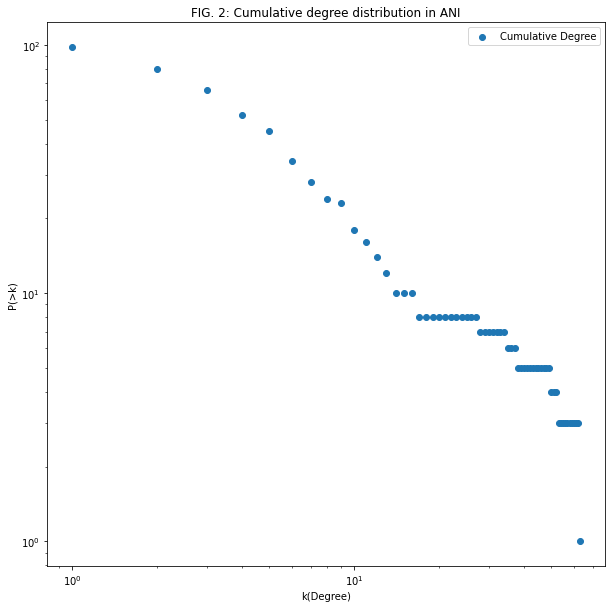

In [39]:
degree_dict, in_degree_dict, degree_dist_dict, in_degree_dist_dict, cumulative_dict, cumulative_in_dict = fig2(DG_unweighted)  # Call fig2 method
keys = []
values = []

max_key = max(sorted(in_degree_dist_dict, reverse = True))                            # Get the maximum key from the sorted in degree distribution
value = 0
for i in range(1, int(max_key)+1):                                                    # For all the degree values ranging from 1 to maximum key
    if i in cumulative_in_dict:                                                       # If that degree value is already present in the cumulative in degree dictionary
        value = cumulative_in_dict[i]                                                 # Get the value
        keys.append(i)                                                                # Append the degree to the keys list
        values.append(value)                                                          # Append the value to the values list
    else:                                                                             # If the degree value is not present in the cumulative in degree dictionary
        keys.append(i)                                                                # Append the degree to the keys list
        values.append(value)                                                          # Append the previous value to the values list

scatter_label = "Cumulative Degree"                                                   # Sets the value of the legend label
title = "FIG. 2: Cumulative degree distribution in ANI"                               # Sets the title of the plot
xlabel = "k(Degree)"                                                                  # Sets the x-axis label of the plot
ylabel = "P(>k)"                                                                      # Sets the y-axis label of the plot
fig_name = "fig2"                                                                     # Sets the figure name to save the image on drive
plotGraph(keys, values, title, xlabel, ylabel, fig_name, scatter_label, scale='log')  # Calls the plotGraph function

## Fig 3: Plot of Cumulative weights distribution in ANI.

In [40]:
"""
Function         : fig3
Input Parameters : 
                    DG_weighted - Weighted DiGraph
                    
Purpose          : Finds the cumulative weights distribution
Returns          : 1. Weight Dictionary, 
                   2. Cumulative Weights Dictionary
"""

# FIG. 3: Cumulative weights distribution in ANI.
def fig3(DG_weighted):
    weight_list = []
    for u,v,weight in DG_weighted.edges(data=True):                                   # For each of the edge(u,v) along with the weights present in the weighted DiGraph
        weight_list.append(weight['weight'])                                          # Append the weights to the weight list
        
    weight_dict = dict(Counter(weight_list))                                          # Capture the count of each of the weights

    cumulative_weight_dict = {}

    sorted_weight_dict = sorted(weight_dict, reverse = True)                          # Sort the weighted dictionary in descending order
    
    prev_val = 0
    for weight in sorted_weight_dict:                                                 # For each value of weight present in the sorted weight dictionary
        prev_val += weight_dict[weight]                                               # Update the cumulative value
        cumulative_weight_dict[weight] = prev_val                                     # Assign the cumulative value to the weight

    # print("cumulative_weight_dict:", cumulative_weight_dict)
    return weight_dict, cumulative_weight_dict                                        # Return the Weight Dictionary and Cumulative Weight Dictionary

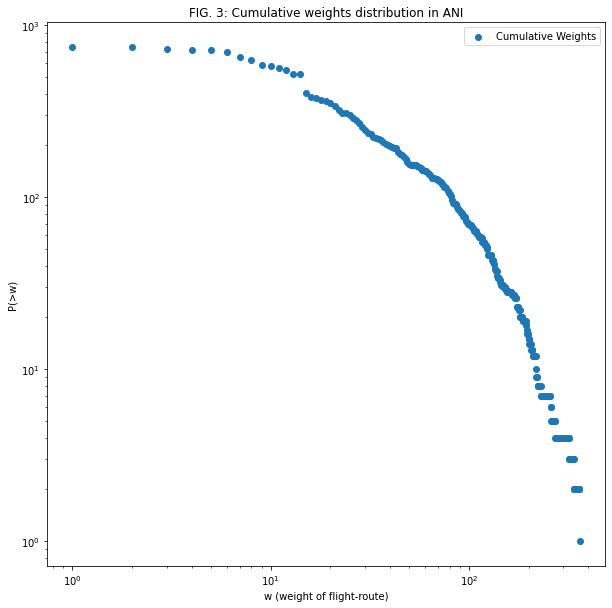

In [41]:
weight_dict, cumulative_weight_dict = fig3(DG_weighted)                             # Call and fetch the Weight Dictionary and Cumulative Weighted Dictionary

keys = []
values = []

max_key = max(sorted(weight_dict, reverse = True))                                  # Get the maximum value of weight present in the Weight Dictionary
value = 0
for i in range(1, int(max_key)+1):                                                  # Loop over the range from 1 to the maximum weight
    if i in cumulative_weight_dict:                                                 # If the weight is present in the cumulative weight dictionary
        value = cumulative_weight_dict[i]                                           # Get the value
        keys.append(i)                                                              # Append the weight to the keys list
        values.append(value)                                                        # Append the value to the values list
    else:                                                                           # If the weight is not present in the cumulative weight dictionary
        keys.append(i)                                                              # Append the weight to the keys list
        values.append(value)                                                        # Append the previous value to the values list

scatter_label = "Cumulative Weights"                                                # Sets the value of the legend label
title = "FIG. 3: Cumulative weights distribution in ANI"                            # Sets the title of the plot
xlabel = "w (weight of flight-route)"                                               # Sets the x-axis label of the plot
ylabel = "P(>w)"                                                                    # Sets the y-axis label of the plot
fig_name = "fig3"                                                                   # Sets the figure name to save the image on drive
plotGraph(keys, values, title, xlabel, ylabel, fig_name, scatter_label, scale='log')  # Calls the plotGraph function

## Fig 4: Plot of Average strength s(k) as a function of degree (k) of nodes.

In [42]:
"""
Function         : fig4
Input Parameters : 
                    DG_weighted - Weighted DiGraph
                    
Purpose          : Finds the average strength
Returns          : Average Strength Dictionary
"""
# FIG. 4: Average strength s(k) as a function of degree (k) of nodes.
def fig4(DG_Weighted):
    strength_dict = findStrength(DG_weighted)                                 # Calls findStrength function to get strength dictionary
    strength_dict = {k: v / 2 for k, v in strength_dict.items()}

    strength_dict_final = {}                                                  # final strength dictionary will store a list of strength corresponding to a degree
    for node in node_list:                                                    # For each node present in the node list of the graph
        in_degree = DG_unweighted.in_degree(node)                             # Capture the in degree of the node
        out_degree = DG_unweighted.out_degree(node)                           # Capture the out degree of the node
      
        if in_degree in strength_dict_final:                                  # If in degree is already present in the final strength dictionary
            strength_list = strength_dict_final[in_degree]                    # Fetch the list already present
            strength_list.append(strength_dict[node])                         # Append the new value of strength
            strength_dict_final[in_degree] = strength_list                    # Assign the updated list to the degree
        else:                                                                 # If the in degree is not present in the final strength dictionary
            strength_list = []                                                # Make an empty list
            strength_list.append(strength_dict[node])                         # Append the value of the strength of the node
            strength_dict_final[in_degree] = strength_list                    # Assign the strength list to the degree

    average_strength_dict = {}

    for degree in strength_dict_final:                                        # Iterate over all the degree values present in the final strength dictionary
        strength_list = strength_dict_final[degree]                           # Capture the strength list against the degree in focus
        average_strength_dict[degree] = np.mean(strength_list)                # assign the average of all strengths against the degree in a new dictionary
        
    del average_strength_dict[0]                                              # Delete the key-value pair against the key-0
    return average_strength_dict                                              # Returns the average strength dictionary

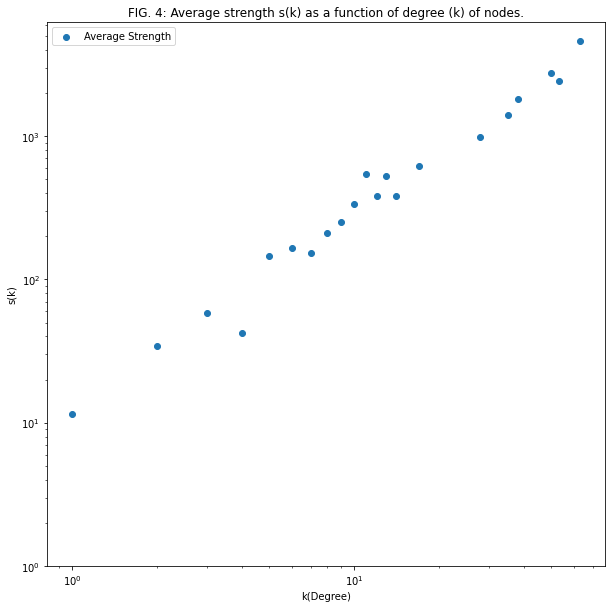

In [43]:
average_strength_dict = fig4(DG_weighted_symm)                                                               # Calls the fig4 method
keys = []
values = []
for key, value in average_strength_dict.items():                                                        # For each pair of degree-average strength present
    keys.append(key)                                                                                    # Append Degree to the keys list
    values.append(value)                                                                                # Append Average Strength to the values list

scatter_label = "Average Strength"                                                                      # Sets the value of the legend label
title = "FIG. 4: Average strength s(k) as a function of degree (k) of nodes."                           # Sets the title of the plot
xlabel = "k(Degree)"                                                                                    # Sets the x-axis label of the plot
ylabel = "s(k)"                                                                                         # Sets the y-axis label of the plot
fig_name = "fig4"                                                                                       # Sets the figure name to save the image on drive
plotGraph(keys, values, title, xlabel, ylabel, fig_name, scatter_label, scale='log', set_ylim = True)   # Calls the plotGraph function

## Fig 5: Plot of Average unweighted (C(k)) and weighted (Cw(k)) clustering coefficients of nodes with degree k.

In [44]:
"""
Function         : plotGraphAdvanced
Input Parameters : 
                    keys1 -  First Set of Values of the X-Axis
                    values1 - First set of Values of the Y-Axis
                    scatter_label1 - The legend label string value for first set of values
                    keys2 -  Second Set of Values of the X-Axis
                    values2 - Second set of Values of the Y-Axis
                    scatter_label2 - The legend label string value for second set of values
                    title  - Sets the title of the graph
                    xlabel - Sets the x-axis value
                    ylabel - Sets the y-axis value
                    fig_name - The figure name with which the figure will be saved on Google Drive

Purpose          : Plots the graph with the requisite parameters
Returns          : Nothing. Only plots the graph and saves it to drive
"""
def plotGraphAdvanced(keys1, values1, scatter_label1, keys2, values2, scatter_label2, title, xlabel, ylabel, fig_name):
    fig = plt.figure(figsize = (10,10))                                                           # Design a figure
    plt.scatter(keys1, values1, label = scatter_label1)                                           # Scatter plot the first set of values
    plt.scatter(keys2, values2, label = scatter_label2)                                           # Scatter plot the second set of values
    ax=plt.gca()                                                 
    ax.set_xscale('log')                                                                          # Set the scale of the X-Axis as the log scale
    ax.set_yscale('log')                                                                          # Set the scale of the Y-Axis as the log scale
    plt.title(title)                                                                              # Set the title
    plt.xlabel(xlabel)                                                                            # Set the X-Axis label
    plt.ylabel(ylabel)                                                                            # Set the Y-Axis label
    plt.legend()                                                                                  # Show the legend
    plt.savefig('/content/drive/MyDrive/NetworkScience/static/images/'+fig_name+'.png')           # Save the figure to drive
    plt.show()                                                                                    # Show the Plot

In [45]:
"""
Function         : calc_unweighted_cc
Input Parameters : 
                    DG_unweighted -  Unweighted DiGraph

Purpose          : Calculates average unweighted clustering coefficient of the unweighted DiGraph
Returns          : Average unweighted clustering coefficient with degree present as key in the dictionary
"""
def calc_unweighted_cc(DG_unweighted):
    clustering_coefficient_unweighted_dict = {}                                               # Dictionary to keep in degree as the key and list of clustering coefficient as value
    average_cc_unweighted_dict = {}                                                           # Dictionary to keep in degree as the key and avergae of cc as value

    for node in node_list:                                                                    # For each node present in the node list
        in_degree = DG_unweighted.in_degree(node)                                             # Finds the in degree of the node in focus
        out_degree = DG_unweighted.out_degree(node)                                           # Finds the out degree of the node in focus
        
        if in_degree in clustering_coefficient_unweighted_dict:                               # If the in degree is already present in the dictionary
            clustering_coefficient_list = clustering_coefficient_unweighted_dict[in_degree]   # Get the list present corresponding to the in degree
            clustering_coefficient_list.append(nx.clustering(DG_unweighted, node))            # Find the clustering coefficient of the current node and append to the list
            clustering_coefficient_unweighted_dict[in_degree] = clustering_coefficient_list   # Assign the updated list against the in degree
        else:                                                                                 # If the in degree is not present in the dictionary
            clustering_coefficient_list = []                                                  # Create a new list
            clustering_coefficient_list.append(nx.clustering(DG_unweighted, node))            # Append the clustering coefficient to the list
            clustering_coefficient_unweighted_dict[in_degree] = clustering_coefficient_list   # Assign the list against the in degree

    for degree in clustering_coefficient_unweighted_dict:                                     # For each degree value present in the dictionary as key
        cc_list = clustering_coefficient_unweighted_dict[degree]                              # Get the list of cc
        average_cc_unweighted_dict[degree] = np.mean(cc_list)                                 # Assign the average of clustering coefficient in a new dictionary
      
    if 0 in average_cc_unweighted_dict:                                                       # If 0 is present in average_cc_unweighted_dict
        del average_cc_unweighted_dict[0]                                                     # Delete it from the average_cc_unweighted_dict
    if 1 in average_cc_unweighted_dict:                                                       # If 1 is present in average_cc_unweighted_dict
        del average_cc_unweighted_dict[1]                                                     # Delete it from the average_cc_unweighted_dict
    return average_cc_unweighted_dict                                                         # Return the average_cc_unweighted_dict

In [46]:
"""
Function         : calculateWeightedCC
Input Parameters : 
                    G -  Weighted DiGraph
                    node - Node of which clustering coefficient needs to be calculated
                    neighbours - neighbours of the node
                    degree_dict - degree dictionary of the node

Purpose          : Calculates Weighted clustering coefficient of the Weighted DiGraph for the node passed as input
Returns          : Weighted Clustering Coefficient of the node
"""

def calculateWeightedCC(G, node, neighbours, degree_dict):
    neigh_comb_list = list(combinations(neighbours, 2))                                       # Finds the all possible neighbour combination
    summation = 0
    for comb_tuple in neigh_comb_list:                                                        # For each possible pair of neighbour
        if G.has_edge(comb_tuple[0], comb_tuple[1]):                                          # If the edge is present between the pair iterated
            local_sum = G[node][comb_tuple[0]]['weight'] + G[node][comb_tuple[1]]['weight']   # Add the weights of edges of both neighbour nodes with the node in focus
            summation += (local_sum*4)                                                        # Add to the summation
    if degree_dict[node] > 1:                                                                 # If the degree is greater than 1
        weighted_cc = summation/(strength_dict[node]*(degree_dict[node] - 1))                 # Divide by strength * (degree of node - 1)
    else:
        weighted_cc = 0                                                                       # Else the weighted clustering coefficient is 0
    return weighted_cc                                                                        # Return the weighted clustering coefficient of the node

In [47]:
"""
Function         : calc_weighted_cc
Input Parameters : 
                    DG_weighted -  Weighted DiGraph
                    degree_dict - Degree Dictionary

Purpose          : Calculates weighted clustering coefficient of the weighted DiGraph
Returns          : Average weighted clustering coefficient with degree present as key in the dictionary
"""
def calc_weighted_cc(DG_weighted, degree_dict):
    clustering_coefficient_weighted_dict = {}                                                 # Dictionary to keep in degree as the key and list of clustering coefficient as value
    average_cc_weighted_dict = {}                                                             # Dictionary to keep in degree as the key and avergae of cc as value

    for node in node_list:                                                                          # For each node present in the node list
        in_degree = DG_weighted.in_degree(node)                                                     # Find the in degree of the node
        out_degree = DG_weighted.out_degree(node)                                                   # Find the out degree of the node
      
        neighbours = [n for n in DG_weighted.neighbors(node)]                                       # Finds the neighbours of the node
        if in_degree in clustering_coefficient_weighted_dict:                                       # If in degree is already present in the dictionary
            clustering_coefficient_list = clustering_coefficient_weighted_dict[in_degree]           # Get the clustering coefficient list already present
            clustering_coefficient_list.append(calculateWeightedCC(DG_weighted, node, neighbours, degree_dict)) # Append the clustering coefficient
            clustering_coefficient_weighted_dict[in_degree] = clustering_coefficient_list           # Assign the updated list against the degree
        else:                                                                                       # If the in degree is not present in the dictonary
            clustering_coefficient_list = []                                                        # Make a new list
            clustering_coefficient_list.append(calculateWeightedCC(DG_weighted, node, neighbours, degree_dict)) # Append the clustering coefficient value
            clustering_coefficient_weighted_dict[in_degree] = clustering_coefficient_list           # Assign the updated list against the degree

    for degree in clustering_coefficient_weighted_dict:                                             # For each degree value present in the dictionary
        cc_list = clustering_coefficient_weighted_dict[degree]                                      # Get the clustering coefficient list
        average_cc_weighted_dict[degree] = np.max(cc_list)                                          # Assign the mean value against the degree
        
    if 0 in average_cc_weighted_dict:                                                               # If 0 is present in average_cc_weighted_dict 
        del average_cc_weighted_dict[0]                                                             # Delete it from the average_cc_weighted_dict
    if 1 in average_cc_weighted_dict:                                                               # If 1 is present in average_cc_weighted_dict
        del average_cc_weighted_dict[1]                                                             # Delete it from the average_cc_weighted_dict

    return average_cc_weighted_dict                                                                 # Returns the average_cc_weighted_dict

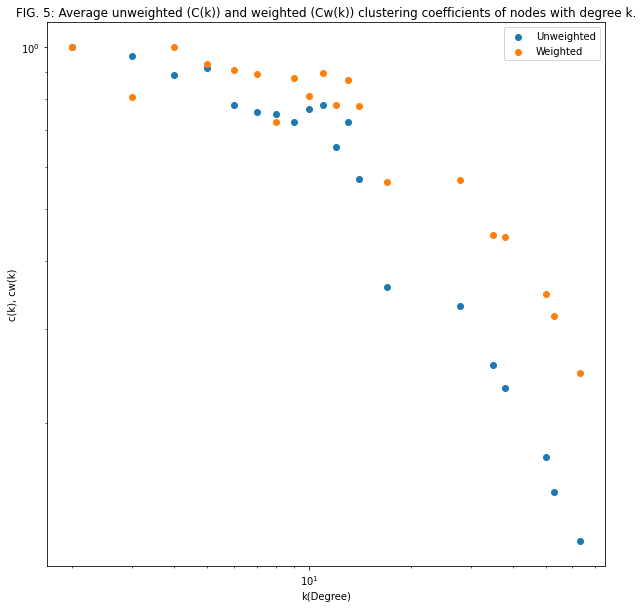

In [48]:
average_cc_unweighted_dict = calc_unweighted_cc(DG_unweighted)                                  # Calls calc_unweighted_cc method to capture average_cc_unweighted_dict
average_cc_weighted_dict = calc_weighted_cc(DG_weighted, degree_dict)                           # Calls calc_weighted_cc method to capture average_cc_weighted_dict

keys = []
values = []
keys_weighted = []
values_weighted = []
for key, value in average_cc_unweighted_dict.items():                                           # For each degree-unweighted cc pair present in average_cc_unweighted_dict
    keys.append(key)                                                                            # Append degree to the keys list
    values.append(value)                                                                        # Append unweighted cc to the values list

for key, value in average_cc_weighted_dict.items():                                             # For each degree-weighted cc pair present in average_cc_weighted_dict
    keys_weighted.append(key)                                                                   # Append degree to the keys_weighted list
    values_weighted.append(value)                                                               # Append weighted cc to the values_weighted list

scatter_label1 = "Unweighted"                                                                                                 # Sets the value of the legend label1
scatter_label2 = "Weighted"                                                                                                   # Sets the value of the legend label2
title = "FIG. 5: Average unweighted (C(k)) and weighted (Cw(k)) clustering coefficients of nodes with degree k."              # Sets the title of the plot
xlabel = "k(Degree)"                                                                                                          # Sets the x-axis label of the plot
ylabel = "c(k), cw(k)"                                                                                                        # Sets the y-axis label of the plot
fig_name = "fig5"                                                                                                             # Sets the figure name to save the image on drive
plotGraphAdvanced(keys, values, scatter_label1, keys_weighted, values_weighted, scatter_label2, title, xlabel, ylabel, fig_name)   # Calls the plotGraphAdvanced function

## Fig 6: Plot of Average unweighted (knn(k)) and weighted (kwnn(k)) degree of nearest neighbors of nodes with degree k.

In [49]:
"""
Function         : fig6
Input Parameters : 
                    DG_weighted - Weighted DiGraph
                    
Purpose          : Finds the Unweighted KNN and Weighted KNN w.r.t each node of degree
Returns          : Unweighted KNN Dictionary and Weighted KNN Dictionary
"""

# FIG. 6: Average unweighted (knn(k)) and weighted (kwnn(k)) degree of nearest neighbors of nodes with degree k.
def fig6(DG_weighted):
    unweighted_knn_dict = nx.k_nearest_neighbors(DG_weighted)                   # Calculates Unweighted KNN corresponding to each degree
    # print('unweighted_knn_dict:', unweighted_knn_dict)

    weighted_knn_dict = nx.k_nearest_neighbors(DG_weighted, weight='weight')    # Calculates Weighted KNN corresponding to each degree
    # print('weighted_knn_dict:', weighted_knn_dict)

    return unweighted_knn_dict, weighted_knn_dict                          # Returns unweighted KNN dictionary and weighted KNN dictionary

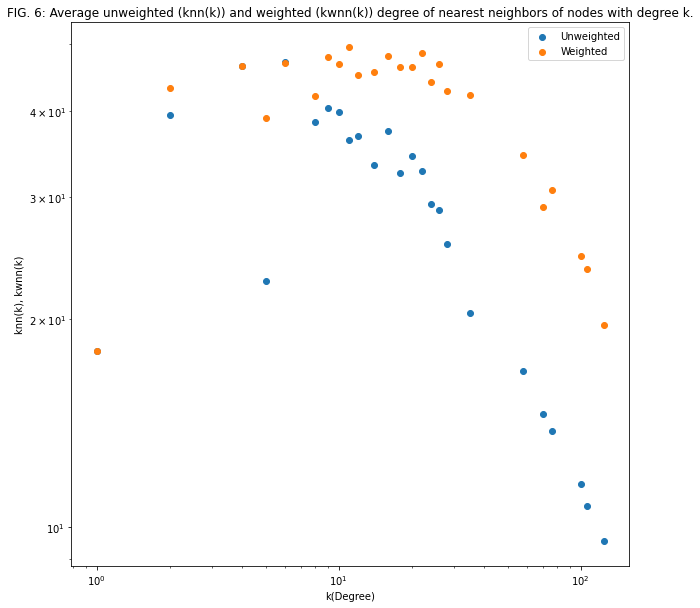

In [50]:
unweighted_knn_dict, weighted_knn_dict = fig6(DG_weighted)                                                    # Calls fig6 method to get unweighted_knn_dict, weighted_knn_dict

keys = []
values = []
keys_weighted = []
values_weighted = []
for key, value in unweighted_knn_dict.items():                                                                # For each degree-unweighted knn present in unweighted_knn_dict
    keys.append(key)                                                                                          # Append degree to keys list
    values.append(value)                                                                                      # Append unweighted knn to values list

for key, value in weighted_knn_dict.items():                                                                  # For each degree-weighted knn present in weighted_knn_dict
    keys_weighted.append(key)                                                                                 # Append degree to keys_weighted list
    values_weighted.append(value)                                                                             # Append weighted knn to values_weighted list

scatter_label1 = "Unweighted"                                                                                                   # Sets the value of the legend label1
scatter_label2 = "Weighted"                                                                                                     # Sets the value of the legend label2
title = "FIG. 6: Average unweighted (knn(k)) and weighted (kwnn(k)) degree of nearest neighbors of nodes with degree k."        # Sets the title of the plot
xlabel = "k(Degree)"                                                                                                            # Sets the x-axis label of the plot
ylabel = "knn(k), kwnn(k)"                                                                                                      # Sets the y-axis label of the plot
fig_name = "fig6"                                                                                                               # Sets the figure name to save the image on drive
plotGraphAdvanced(keys, values, scatter_label1, keys_weighted, values_weighted, scatter_label2, title, xlabel, ylabel, fig_name)   # Calls the plotGraphAdvanced function

In [51]:
visualization_string = encodeString("visualization.png")                        # Get the encoding of visualization.png image
encoded_string1 = encodeString("fig1.png")                                      # Get the encoding of fig1.png image
encoded_string2 = encodeString("fig2.png")                                      # Get the encoding of fig2.png image
encoded_string3 = encodeString("fig3.png")                                      # Get the encoding of fig3.png image
encoded_string4 = encodeString("fig4.png")                                      # Get the encoding of fig4.png image
encoded_string5 = encodeString("fig5.png")                                      # Get the encoding of fig5.png image
encoded_string6 = encodeString("fig6.png")                                      # Get the encoding of fig6.png image
map_string = encodeString("map.png")                                            # Get the encoding of map.png image

# Computation of Centrality Measures

In [52]:
betweenness_centrality = nx.betweenness_centrality(DG_unweighted)                 # Finds the betweenness centrality of unweighted graph
betweenness_centrality_top5_unw = sorted(betweenness_centrality.items(), key=lambda kv: kv[1], reverse=True)[0:5] # Reverse sort and get top 5
print("Top 5 Airports Based on High Betweenness Centrality Unweighted:", betweenness_centrality_top5_unw)

Top 5 Airports Based on High Betweenness Centrality Unweighted: [('DEL', 0.28352597125908535), ('BOM', 0.20976358062954498), ('HYD', 0.1562000852657348), ('BLR', 0.1461505015373755), ('CCU', 0.11275939656204138)]


In [53]:
betweenness_centrality = nx.betweenness_centrality(DG_weighted, weight='weight')  # Finds the betweenness centrality of weighted graph
betweenness_centrality_top5_w = sorted(betweenness_centrality.items(), key=lambda kv: kv[1], reverse=True)[0:5] # Reverse sort and get top 5
print("Top 5 Airports Based on High Betweenness Centrality Weighted:", betweenness_centrality_top5_w)

Top 5 Airports Based on High Betweenness Centrality Weighted: [('DEL', 0.30400098183603336), ('BOM', 0.2630093274423171), ('HYD', 0.18417490707623257), ('AJL', 0.11468195525632931), ('BLR', 0.1133494634967389)]


In [54]:
degree_centrality = nx.degree_centrality(DG_unweighted)                           # Finds the degree centrality of unweighted network
degree_centrality_top5 = sorted(degree_centrality.items(), key=lambda kv: kv[1], reverse=True)[0:5] # Reverse sort and get top 5
print("Top 5 Airports Based on High Degree Centrality:", degree_centrality_top5)

Top 5 Airports Based on High Degree Centrality: [('DEL', 1.2755102040816326), ('BOM', 1.0816326530612244), ('HYD', 1.0816326530612244), ('BLR', 1.0204081632653061), ('CCU', 0.7755102040816326)]


In [55]:
"""
Function         : getTotalFlights
Input Parameters : 
                    DG_weighted - Weighted DiGraph
                    
Purpose          : Finds the Total number of flights in the weighted network
Returns          : Total number of flights plying per week
"""
def getTotalFlights(DG_weighted):
    total_flights = 0                                       # Assign initial value as 0
    for u,v,weight in DG_weighted.edges(data=True):         # For the triplet (From Airport, To Airport, Number of flights per week) present in the DiGraph
        total_flights += weight['weight']                   # Add the weight to total flights
    return total_flights                                    # Return Total Flights

In [56]:
"""
Function         : getAirlineNames
Input Parameters : 
                    schedule_dict - Dictionary containing the schedule of each airline corresponding to the airline name
                    
Purpose          : Finds the Airline names
Returns          : String of all airlines separated by comma
"""
def getAirlineNames(schedule_dict):
    airlines = []
    for key in schedule_dict.keys():                    # For all the airlines present as keys
        airline_name = key.split("_")[0]                  # Get the Airline name
        airlines.append(airline_name)                     # Append to a list
    airline_names = ', '.join(airlines)                 # Join the list separated by comma
    return airline_names                                # Return the airline names string

In [57]:
"""
Function         : getAirportList
Input Parameters : 
                    DG_unweighted - Unweighted DiGraph
                    reverse_airport_map - mapping (IATA:City)
                    
Purpose          : Finds and returns all the airports present in the unweighted DiGraph
Returns          : Dictionary Containing (IATA:City) mapping
"""
def getAirportList(DG_unweighted, reverse_airport_map):
    airport_dict = {}
    node_list = list(DG_unweighted.nodes())                           # Capture the list of nodes
    for node in node_list:                                            # For each node present in the node list
        airport_dict[node] = reverse_airport_map[node]                  # Store the Airport corresponding to its IATA
    return airport_dict                                               # Return dictionary containing airport name corresponding to its IATA

## Fetching the Shortest Path

In [58]:
"""
Function         : findShortestPath
Input Parameters : 
                    from_airport - Starting point of shortest path
                    to_airport - Ending point of the shortest path
                    
Purpose          : Finds the shortest path between two airports
Returns          : Shortest path route as well as the encoded map
"""
def findShortestPath(from_airport, to_airport):
    map_name = "map_"+from_airport+"_"+to_airport+".png";                                           # Sets the name with which the image will be saved in drive
    shortest_path_list = nx.shortest_path(DG_unweighted, source=from_airport, target=to_airport)    # Finds the shortest path between two airports
    shortest_path_graph = nx.DiGraph()                                                              # Creates a new DiGraph
    for i in range(len(shortest_path_list)-1):                                                      # For the airports present in the shortest path
        shortest_path_graph.add_edge(shortest_path_list[i], shortest_path_list[i+1])                  # Create an edge between the consecutive airports
    print('edges:', shortest_path_graph.edges())

    shortest_path_route_list = []
    for airport in shortest_path_list:                                                                      # For each airport present in the shortest path
        shortest_path_route_list.append(reverse_airport_map[airport] + ' ( '+ airport +' ) ')                 # Append it to a list in format (Airport(IATA))

    shortest_path_route = ' ---> '.join(shortest_path_route_list)                                           # Join the list values separated by --->

    plt.figure(figsize = (10,10))                                                                           # Design a figure
    m = Basemap(
          projection='merc',
          llcrnrlon=68.,
          llcrnrlat=6.,
          urcrnrlon=97.,
          urcrnrlat=37.,
          resolution='l',
          suppress_ticks=True)                                                                            # Draw a basemap with bottom left and upper right lat. long.
    mx, my = m((latlong_df['Longitude'].values).astype(float), (latlong_df['Latitude'].values).astype(float)) # Assign values of latitude and longitude
    pos = {}
    for count, elem in enumerate (latlong_df['IATA_Code']):                                                 # Iterate over each IATA Code
        pos[elem] = (mx[count], my[count])                                                                    # Set the latitude and longitude value corresponding to each Airport code

    nx.draw_networkx_nodes(G = shortest_path_graph, pos = pos, nodelist = shortest_path_graph.nodes(),
                          node_color = 'r', alpha = 0.8,
                          node_size = 1000)                                                               # Draw the nodes

    nx.draw_networkx_labels(G = shortest_path_graph, pos = pos, font_size=10)                             # Draw the labels

    nx.draw_networkx_edges(G = shortest_path_graph, pos = pos, edge_color = 'black', 
                          alpha=1, arrows = True, arrowsize=20)                                           # Draw the edges

    m.drawmapboundary(fill_color='aqua')                                                                    # Draw the map boundary

    m.bluemarble()
    m.drawcoastlines(linewidth=1)                                                                           # Draw the coastal lines
    m.fillcontinents(alpha=0.7, lake_color='aqua')                                                          # Fill the lakes in continents with aqua color
    m.drawcountries(linewidth = 3)                                                                          # Draw the country boundaries
    m.drawstates(linewidth = 0.2)                                                                           # Draw the states

    line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")             # Draw the legend for airports
    line2 = mlines.Line2D(range(1), range(1), color="black", marker='',markerfacecolor="black")             # Draw the legend for edges
    plt.legend((line1, line2), ('Airports', 'Routes'), loc=4, fontsize = 'large')                           # Draw the legend
    plt.title("Shortest Path Route", fontsize = 20)                                                         # Set the title
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/NetworkScience/static/images/'+map_name)                            # Saves the figure to drive
    plt.show()                                                                                              # Shows the plot

    shortest_path_string = encodeString(map_name)                                                           # Base 64 Encoding of the image
    return shortest_path_string, shortest_path_route                                                        # Return Encoded Image and the shortest path route

# Running the Flask Application

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://880329fc9e14.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [14/Apr/2021 07:35:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2021 07:35:17] "GET /content/drive/MyDrive/NetworkScience/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Apr/2021 07:35:18] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Apr/2021 07:35:22] "GET /shortestpath HTTP/1.1" 200 -


from_airport: VTZ
to_airport: SXR
edges: [('VTZ', 'DEL'), ('DEL', 'SXR')]


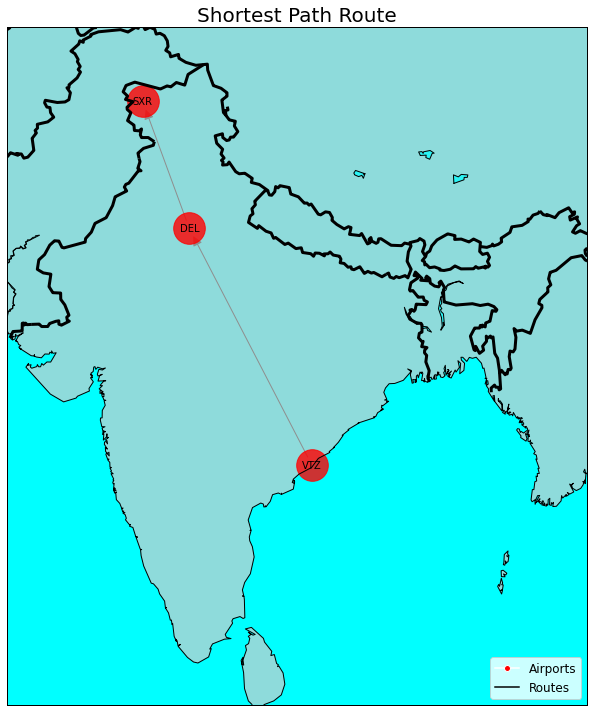

127.0.0.1 - - [14/Apr/2021 07:35:38] "POST /shortestPathResult HTTP/1.1" 200 -


In [60]:
# Import Flask related Dependencies
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__, template_folder='/content/drive/MyDrive/NetworkScience')
run_with_ngrok(app)


@app.route("/")
def home():                                                                                   # For routing to Dashboard(Initial Screen)
    css_file='/content/drive/MyDrive/NetworkScience/styles.css'
    return render_template('dashboard.html',                                                  # Render the template dashboard.html with the parameters required
                           airportCount=len(DG_unweighted), 
                           flightRouteCount=len(DG_unweighted.edges()),
                           flightCount=getTotalFlights(DG_weighted), 
                           css=css_file,
                           airlineCount=len(schedule_dict.keys()), 
                           airlineNames=getAirlineNames(schedule_dict),
                           avgDegree=str(round(average_degree,3)),
                           avgShortestPathLengthANI=str(round(avg_shortest_path_length_ani,3)), 
                           avgCCANI=str(round(avg_clustering_coef_ani,3)),
                           avgShortestPathLengthRN=str(round(avg_shortest_path_length_rn,3)), 
                           avgCCRN=str(round(avg_clustering_coef_rn,3)),
                           betweennessCentrality_unw=betweenness_centrality_top5_unw, 
                           betweennessCentrality_w=betweenness_centrality_top5_w, 
                           degreeCentrality=degree_centrality_top5)


@app.route("/figures")                                                                          # For routing to View Graphs
def figures():
    return render_template("figures.html",                                                      # Render the template figures.html with the parameters required
                           image_data1=encoded_string1.decode('utf-8'),
                           image_data2=encoded_string2.decode('utf-8'),
                           image_data3=encoded_string3.decode('utf-8'),
                           image_data4=encoded_string4.decode('utf-8'),
                           image_data5=encoded_string5.decode('utf-8'),
                           image_data6=encoded_string6.decode('utf-8'))


@app.route("/interactive")                                                                      # For routing to Interactive Visualization
def interactive():
    return render_template("interactive-vis.html")                                              # Render the template interactive-vis.html 


@app.route("/visualization")                                                                    # For routing to Visualization
def visualization():
    return render_template("visualization.html",                                                # Render the template visualization.html with the parameters required
                         visualizaton_data=visualization_string.decode('utf-8'))


@app.route("/map")                                                                              # For routing to View Map 
def map():
    return render_template("map.html",                                                          # Render the template map.html with the parameters required 
                         map_data=map_string.decode('utf-8'))
  

@app.route("/shortestpath")                                                                     # For routing to Fetch Shortest Path
def shortestpath():
    return render_template("shortestpath.html",                                                 # Render the template shortestpath.html with the parameters required
                         airport_iata=getAirportList(DG_unweighted, reverse_airport_map))
  

@app.route("/shortestPathResult", methods = ['POST', 'GET'])                                    # For internal routing to fetch the result of shortest path
def shortestPathResult():
    if request.method == 'POST':
        from_airport = request.form['fromAirport']
        to_airport = request.form['toAirport']
        print('from_airport:', from_airport)
        print('to_airport:', to_airport)
        shortest_path_string, shortest_path_route = findShortestPath(from_airport, to_airport)
    return render_template("shortestpathresult.html",                                           # Render the template shortestpathresult.html with the parameters required
                         shortest_path = shortest_path_string.decode('utf-8'),
                          shortestPathRoute=shortest_path_route)


app.run()

# Conclusion and Results

## Results

1. Topological Analysis

>> The Airport Network of India is a small world network as it has a small average shortest path length having value 2.19 comparable to the corresponding random network which comes out to be 2.27. Also, the custering coefficient is very high for ANI which comes out to be 0.663 which is somewhat greater in the order of magnitude as compared to that of the random network which comes out to be 0.076.

2. Shortest Path Analysis - There are 9604 distinct flight routes.

*   745 direct flights from one airport to other.
*   6172 paths require changing the flight once.
*   2538 paths require changing the flight twice.
*   146 and 3 paths requires the passenger to change the flight three and four times respectively which can be quite tiring.

>> In short, 98.4% of flights require changing the flight only twice to reach from a particular point to the other point.

3. Cumulative Degree Distribution in ANI

>> Degree Distribution shows a power law fit on the log-log scale. This shows the scale free nature of the ANI.

4. Cumulative Weights Distribution in ANI

>> Weights distribution plot shows somewhat right skewed distribution.

5. Strength Vs Degree

>> The strength of a node represents the total traffic handled by the node per week. i.e. the number of flights handled by that particular airport in this context. The strength varies linearly with the degree on the log-log scale. It implies if the airport is larger, it handles more traffic.

6. Variation of Unweighted and Weighted Clustering coefficients w.r.t. degree

>> The inference that can be drawn from this plot of unweighted and weighted clustering coefficients with the degree is that with the increasing degree, the unweighted clustering coefficient tends to decrease. This can be attributed to the fact that Hubs tend to connect to the airports which are themselves not connected. Hubs are the critical link between these two airports. The weighted clustering coefficient shows a similar behaviour of power law decay same as that found in unweighted clustering coefficient. However, weighted clustering coefficient is greater than its unweighted counterpart. Airports have high tendency to form interconnected groups with the hubs.

7. Variation of Unweighted and Weighted KNN w.r.t. degree

>> This plot shows that for the degree value less than 9, there is neither assortative nor disassortative mixing. However, for degree values greater than 9, it shows decreasing nature which implies disassortative mixing. This can be attributed to the fact that high degree nodes are connected to many low degree nodes.

## Conclusion

1. The Airport Network of India is a small world network following the scale free degree distribution. 

2. The traffic is concentrated on the prominent hubs which are profitable to the air travel service providers and hence most of the flights arrives to and departure from these hubs. These hubs are the metro cities and the cities which are IT hubs.

3. From the previous study done, the network has grown in its size to provide better services to the travellers but still exhibits the same characteristics as defined in the research paper "Analysis of the Airport Network of India as a complex weighted network".

4. Betweenness centrality shows the important nodes present in the network. The betweenness centrality for unweighted graph shows the expected result with Delhi, Mumbai, Hyderabad, Bangalore and Kolkata as the top 5 nodes with highest value which is justified as these are the hubs. However, the betweenness centrality value for the weighted graph shows the unexpected airport of Aizawl being added to the top 5 list. This shows that although the airport is having a low degree but still it is an important node or the critical node present in the airport network. It shows the robustness of the network.

5. The development of the front end based tool provides an easy access to the person looking to get the insights and interact with the system.
